In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

In [2]:
# read data
df = pd.read_csv('../data/Test/unwinded_merged_OVS_2016-19.csv')
with open('../data/Test/label_map.json', 'r') as json_file:
    label_map = json.load(json_file)

/tmp/ipykernel_155/708755072.py:2: DtypeWarning: Columns (13,20,23,26,37,40,46,59,62,67,70,90,109,111,113,115,117,120,122,125,132,139,145,147,149,154,159,161,170,176,181,183,185,187,189,191,193,209,215,220,222,224,226,228,232,234,237,239,256,259,262,287,291,303,307,327,340,344,364,399,406,420,430,441,454,481,491,496,512,519,525,543,547,551,674,706,758,764,768,773,777,781,786,804,806,808,983,1005,1006,1007,1009,1121,1123,1126,1127,1130,1131,1142,1143,1144,1146,1147,1158,1164,1170,1176,1178,1183,1200,1202,1228,1238,1239,1243,1245,1251,1252,1254,1255,1256,1257,1258,1262,1288,1300,1311) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/Test/unwinded_merged_OVS_2016-19.csv')


In [3]:
def StackedHorizontalBar(df, col):
    value_counts = df[col].value_counts(dropna = False).sort_index().reset_index().T
    legend, value_counts = value_counts.iloc[0], value_counts[1:]
    value_counts.columns = legend
    ax = value_counts.plot(kind = 'barh', stacked = True, figsize = (10, 1), cmap = 'viridis')
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend(loc = 'upper left', bbox_to_anchor = (0, 1.5+0.25*int(len(legend)/5)), ncol = min(len(legend),5))
    plt.show()

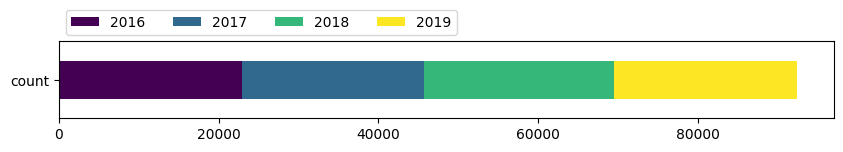

In [4]:
# years of data

df = df.rename(columns = {'year': 'YEAR'})
StackedHorizontalBar(df, 'YEAR')

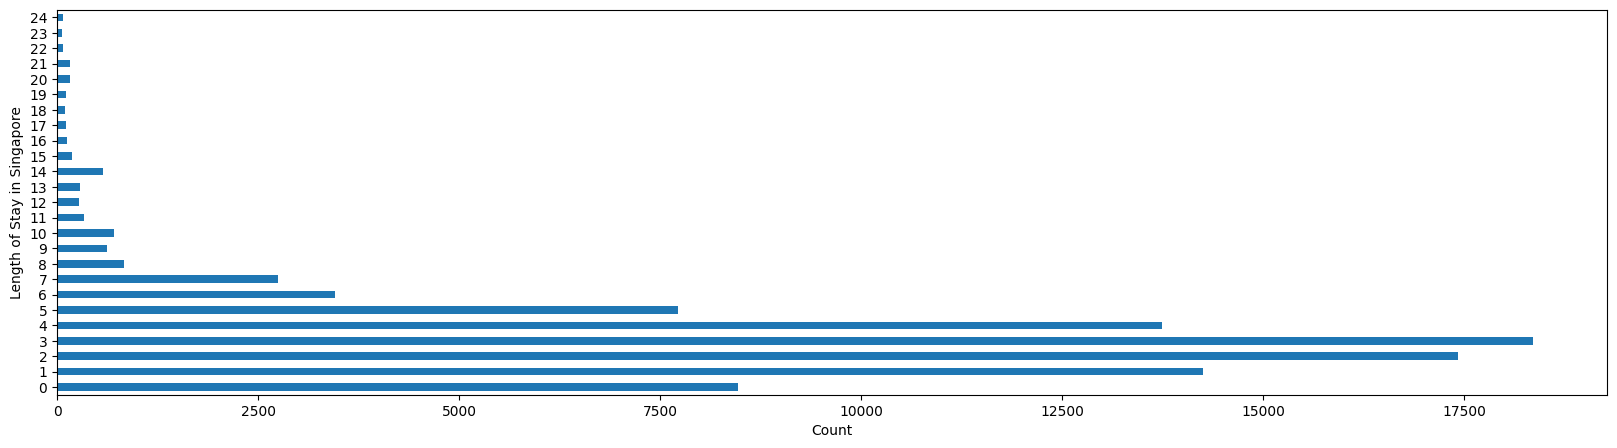

In [5]:
# date of departure = date of arrival + length of stay
# month of arrival = month(date of arrival)
# month of departure = month(date of departure)

df['DATE_OF_ARRIVAL'] = pd.to_datetime(df['a7'])
df['DATE_OF_DEPARTURE'] = df['DATE_OF_ARRIVAL'] + pd.to_timedelta(df['b10'], unit = 'd')
df['MONTH_OF_ARRIVAL'] = df['DATE_OF_ARRIVAL'].dt.month.astype('Int64')
df['MONTH_OF_DEPARTURE'] = df['DATE_OF_DEPARTURE'].dt.month.astype('Int64')

# length of stay

df['LENGTH_OF_STAY'] = df['b10'].astype('Int64').fillna(pd.to_timedelta(df['DATE_OF_DEPARTURE'] - df['DATE_OF_ARRIVAL'], unit = 'd'))

ax = df['LENGTH_OF_STAY'].value_counts()\
                         .sort_index()\
                         .head(25)\
                         .plot(kind = 'barh',
                               figsize = (20,5))
ax.set_ylabel("Length of Stay in Singapore")
ax.set_xlabel("Count")
plt.show()

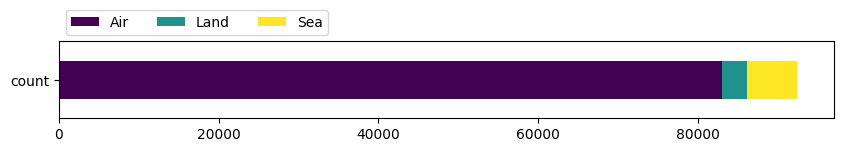

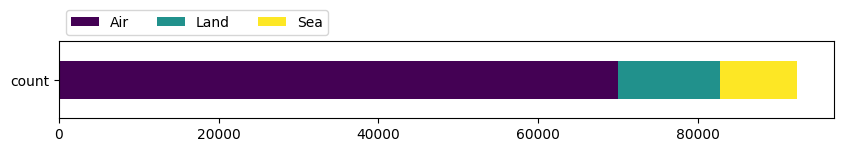

In [6]:
# mode of transport (depature/arrival) = air/land/sea

df['MODE_OF_ARRIVAL'] = df['b2'].astype('Int64').astype(str).map(label_map['b2'])
df['MODE_OF_DEPARTURE'] = df['m1'].astype('Int64').astype(str).map(label_map['m1'])

mode_counts1 = df['MODE_OF_ARRIVAL'].value_counts(dropna = False).reset_index().rename(columns = {'index': 'Value', 0: 'Count'})
mode_counts2 = df['MODE_OF_DEPARTURE'].value_counts(dropna = False).reset_index().rename(columns = {'index': 'Value', 0: 'Count'})

StackedHorizontalBar(df, 'MODE_OF_ARRIVAL')
StackedHorizontalBar(df, 'MODE_OF_DEPARTURE')

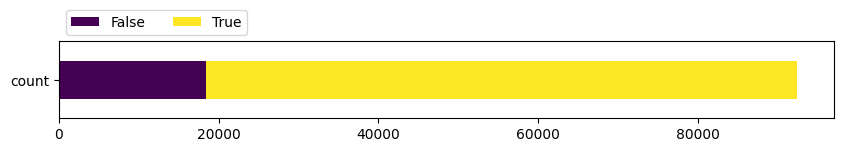

In [7]:
# language of interview
# convert to boolean English and non-English

df = df.rename(columns = {'languageq': 'LANGUAGE_OF_INTERVIEW'})
df['INTERVIEW_IN_ENGLISH'] = (df['LANGUAGE_OF_INTERVIEW'] == 1)
df['INTERVIEW_IN_ENGLISH'] = df['INTERVIEW_IN_ENGLISH'].where(df['LANGUAGE_OF_INTERVIEW'] != -1, pd.NA)

StackedHorizontalBar(df, 'INTERVIEW_IN_ENGLISH')

In [8]:
# type of passenger

# note: this column seems to be already filtered to departing passengers only so can be dropped
df = df.rename(columns = {'a1': 'PASSENGER_TYPE'})

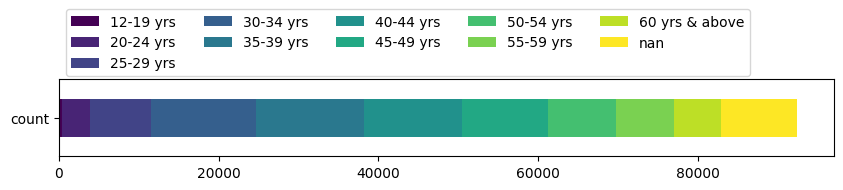

In [9]:
# age band

df['AGE_BAND'] = df['a2.r'].astype('Int64').astype(str).map(label_map['a2.r.10l'])

StackedHorizontalBar(df, 'AGE_BAND')

% MISSING: 0.00%


Text(0.5, 0, 'Count')

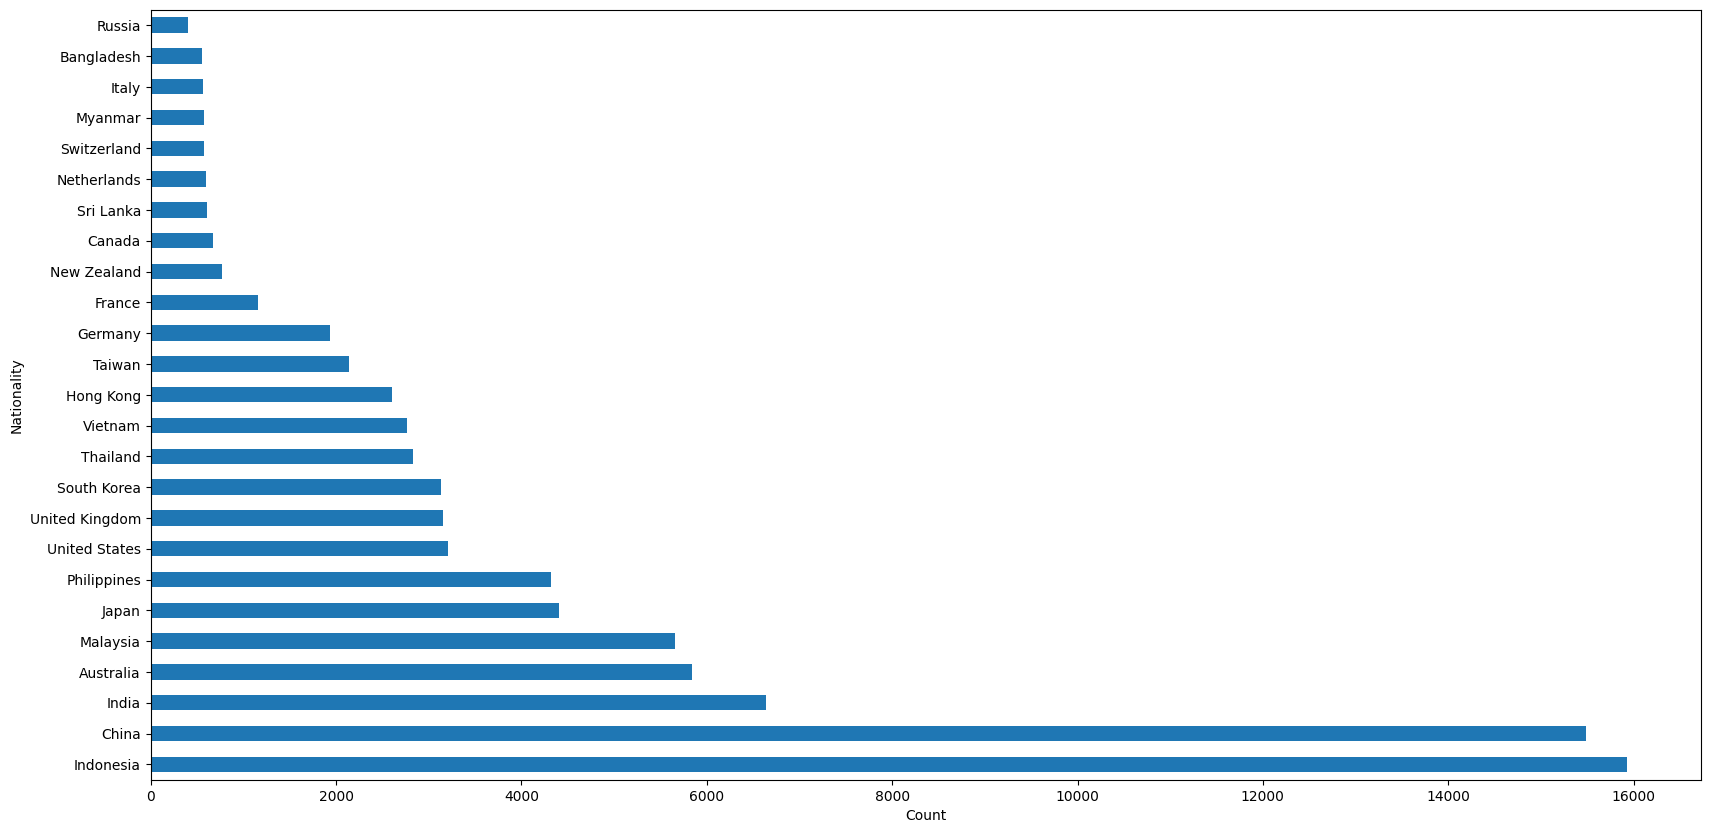

In [10]:
# nationality

df['a4.raw'] = df['a4'].astype('Int64').astype(str).map(label_map['a4'])
df['NATIONALITY'] = df['a4.raw'].map(label_map['NATIONALITY_TO_COUNTRY'])
df['NATIONALITY'] = df['NATIONALITY'].fillna(df['a4.raw'])


print(f"% MISSING: {df['NATIONALITY'].isnull().mean()*100:.2f}%")

ax = df['NATIONALITY'].value_counts()\
                      .nlargest(25)\
                      .plot(kind = 'barh',
                            figsize = (20,10))
ax.set_ylabel("Nationality")
ax.set_xlabel("Count")

% MISSING: 0.00%


Text(0.5, 0, 'Count')

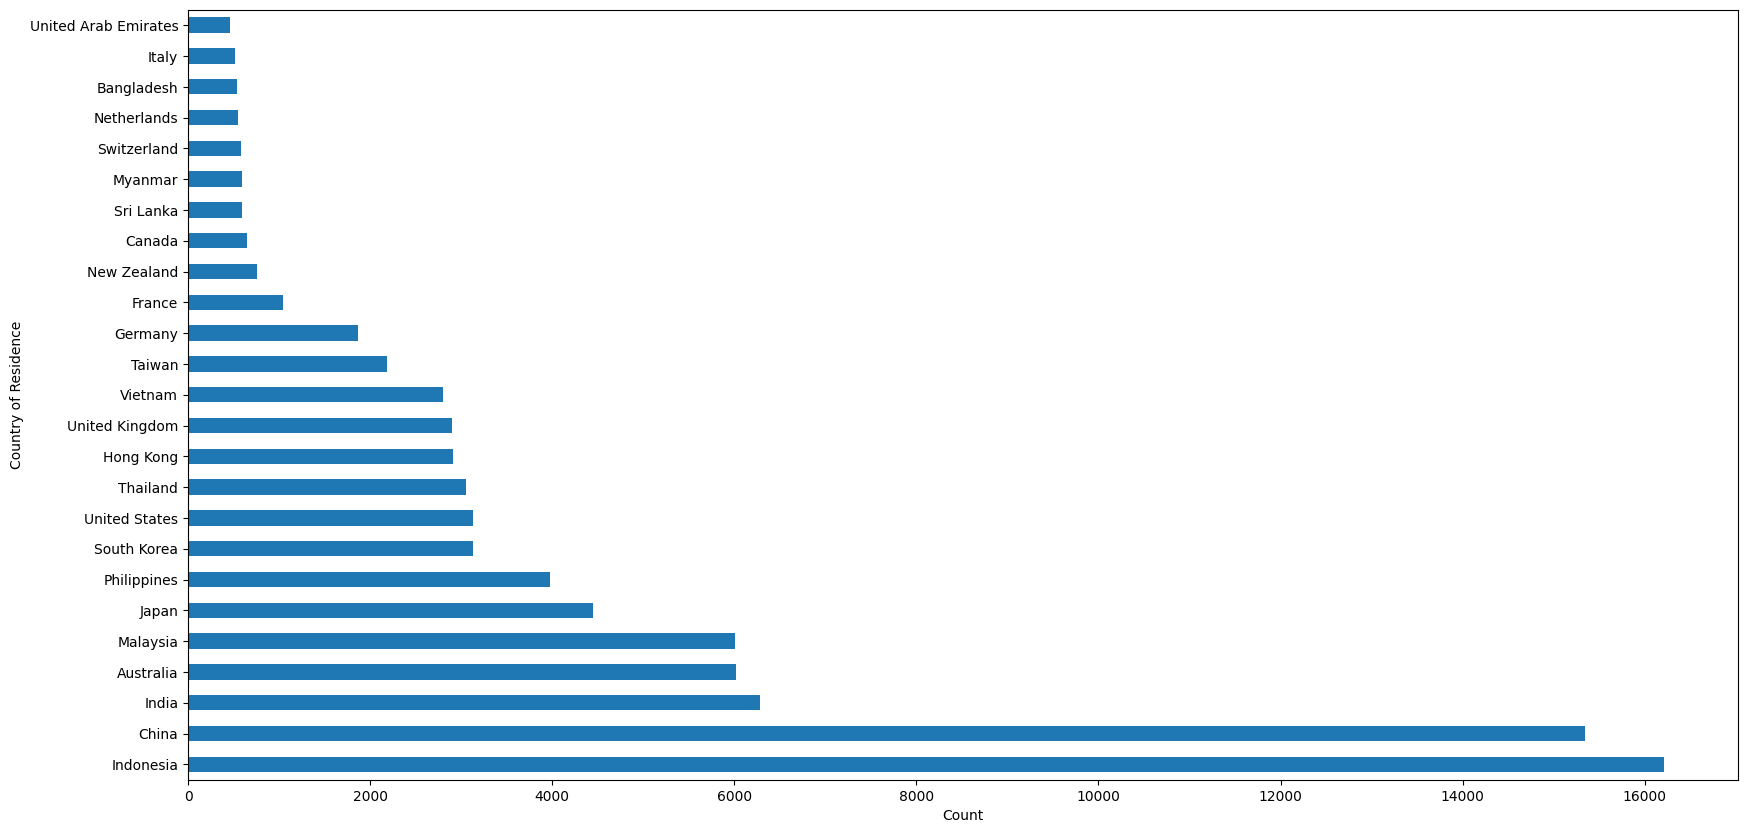

In [11]:
# country of residence

df['COUNTRY_OF_RESIDENCE'] = df['a5'].astype('Int64').astype(str).map(label_map['a5'])
print(f"% MISSING: {df['COUNTRY_OF_RESIDENCE'].isnull().mean()*100:.2f}%")

ax = df['COUNTRY_OF_RESIDENCE'].value_counts()\
                               .nlargest(25)\
                               .plot(kind = 'barh',
                                     figsize = (20,10))
ax.set_ylabel("Country of Residence")
ax.set_xlabel("Count")

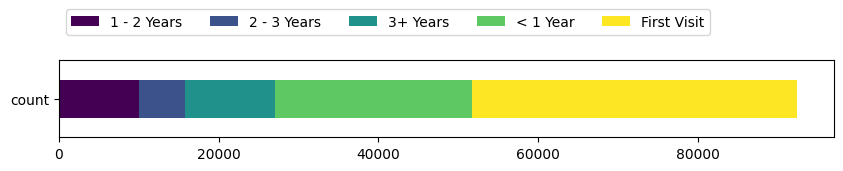

In [12]:
# time since last visit

time_map = {
    0: 'First Visit',
    1: '< 1 Year',
    2: '1 - 2 Years',
    3: '2 - 3 Years',
    4: '3+ Years'
}
df['TIME_SINCE_LAST_VISIT'] = df['b1b'].astype('Int64').fillna(0).map(time_map)

StackedHorizontalBar(df, 'TIME_SINCE_LAST_VISIT')

% MISSING: 83.12%


Text(0.5, 0, 'Count')

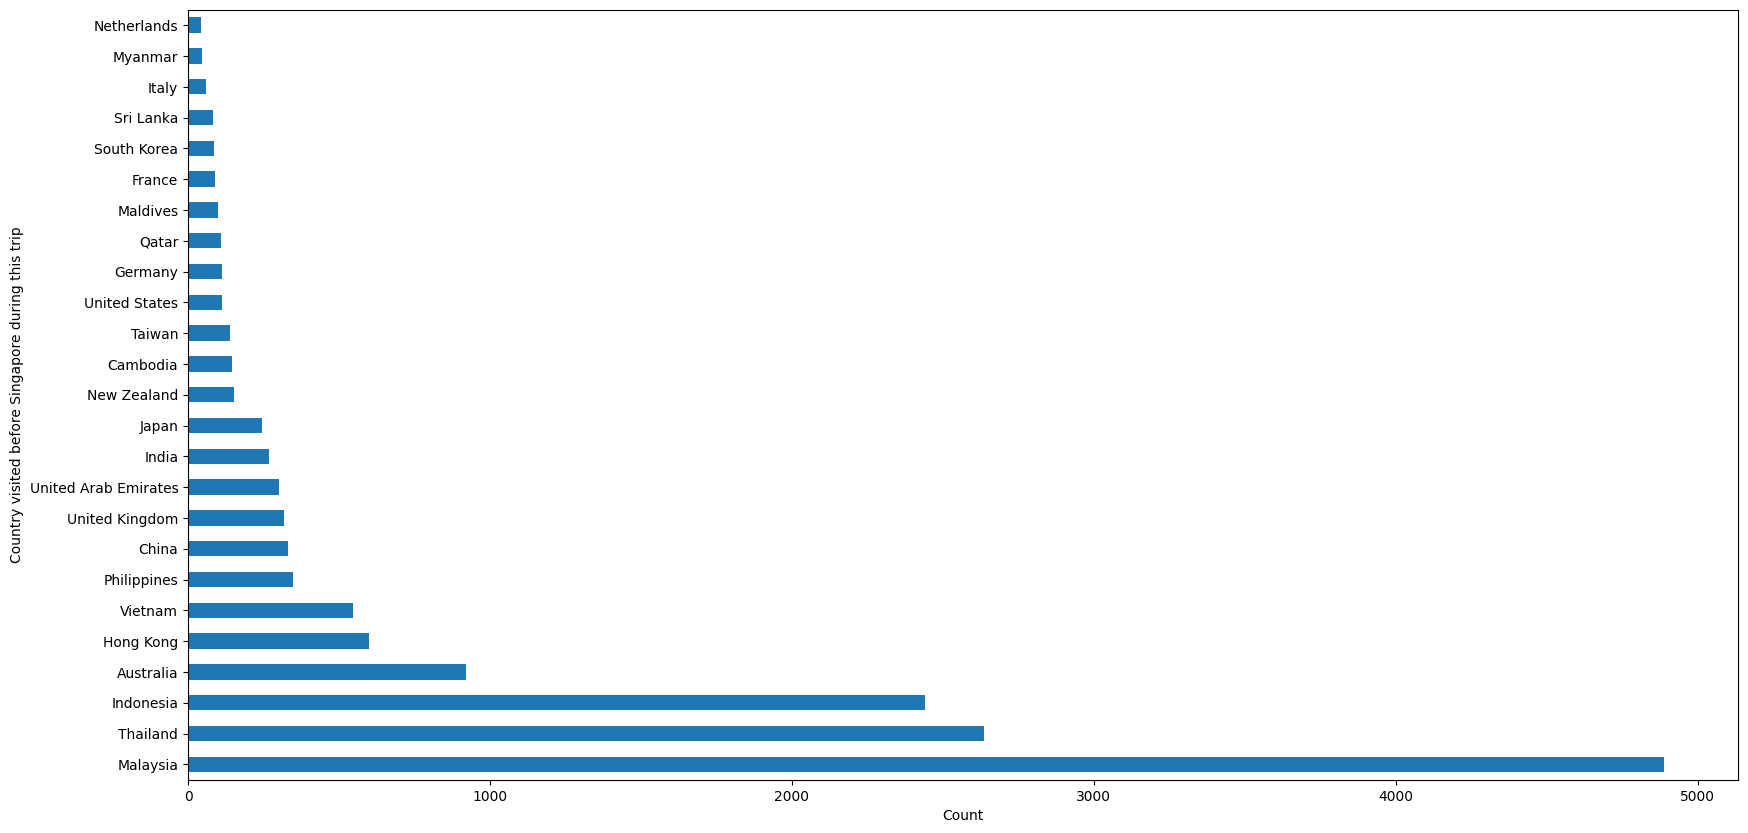

In [13]:
df['Country before SG'] = df['b7a'].astype('Int64').astype(str).map(label_map['b7a'])
print(f"% MISSING: {df['Country before SG'].isnull().mean()*100:.2f}%")

ax = df['Country before SG'].value_counts()\
                            .nlargest(25)\
                            .plot(kind = 'barh',
                                  figsize = (20,10))
ax.set_ylabel("Country visited before Singapore during this trip")
ax.set_xlabel("Count")

% MISSING: 73.05%


Text(0.5, 0, 'Count')

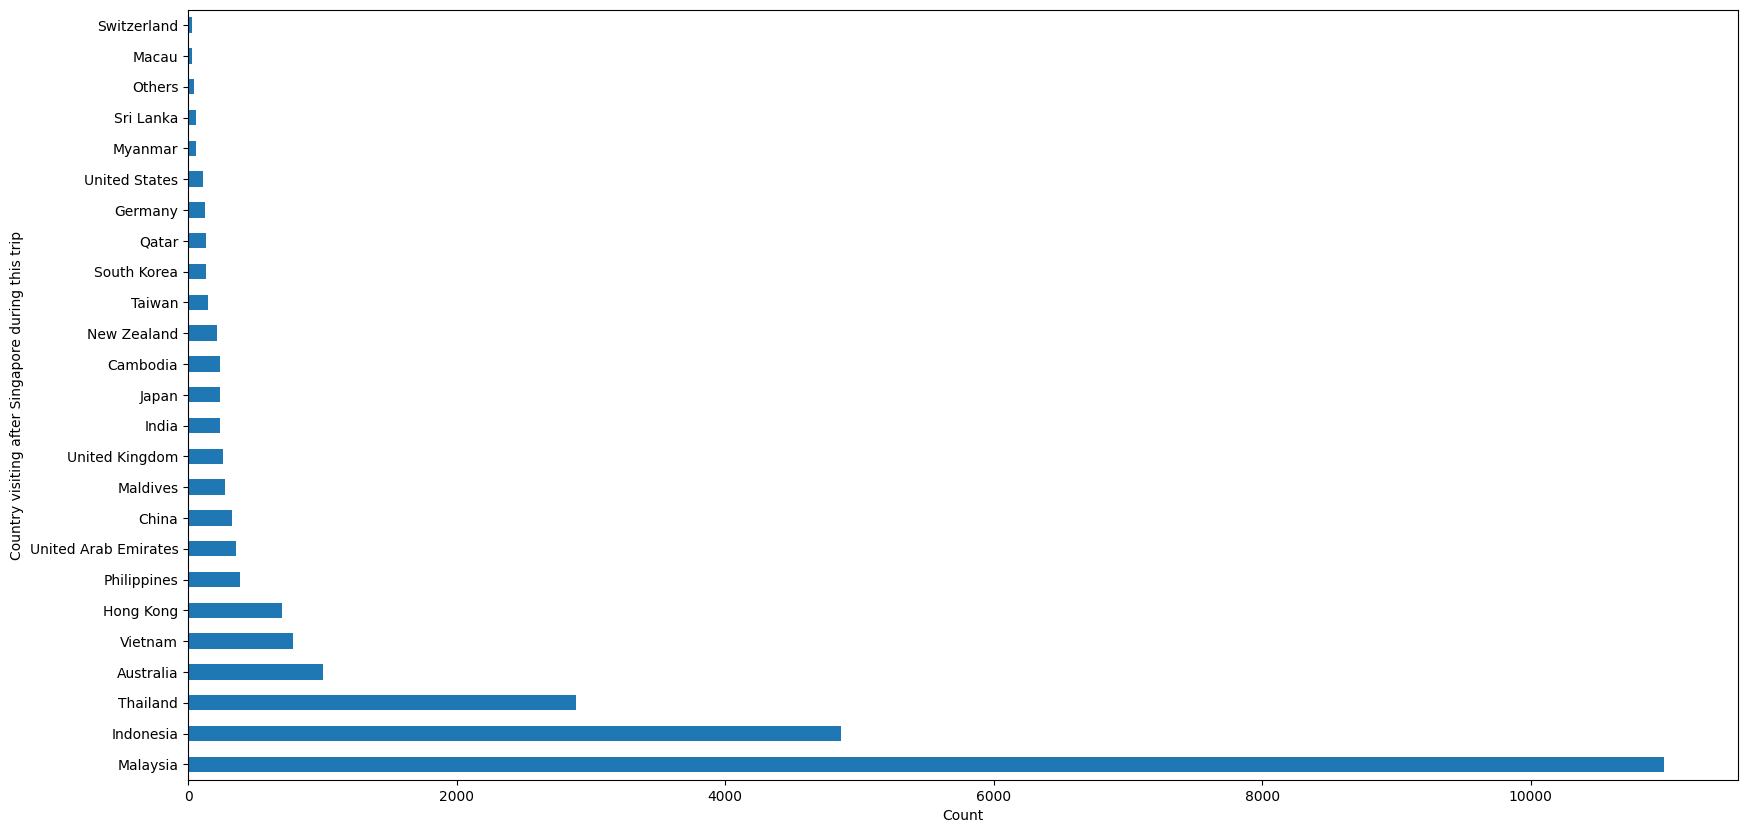

In [14]:
df['Country after SG'] = df['b9a'].astype('Int64').astype(str).map(label_map['b9a'])
print(f"% MISSING: {df['Country after SG'].isnull().mean()*100:.2f}%")

ax = df['Country after SG'].value_counts()\
                            .nlargest(25)\
                            .plot(kind = 'barh',
                                  figsize = (20,10))
ax.set_ylabel("Country visiting after Singapore during this trip")
ax.set_xlabel("Count")

% MISSING (before imputation): 83.12%
% MISSING (after imputation): 0.00%


Text(0.5, 0, 'Count')

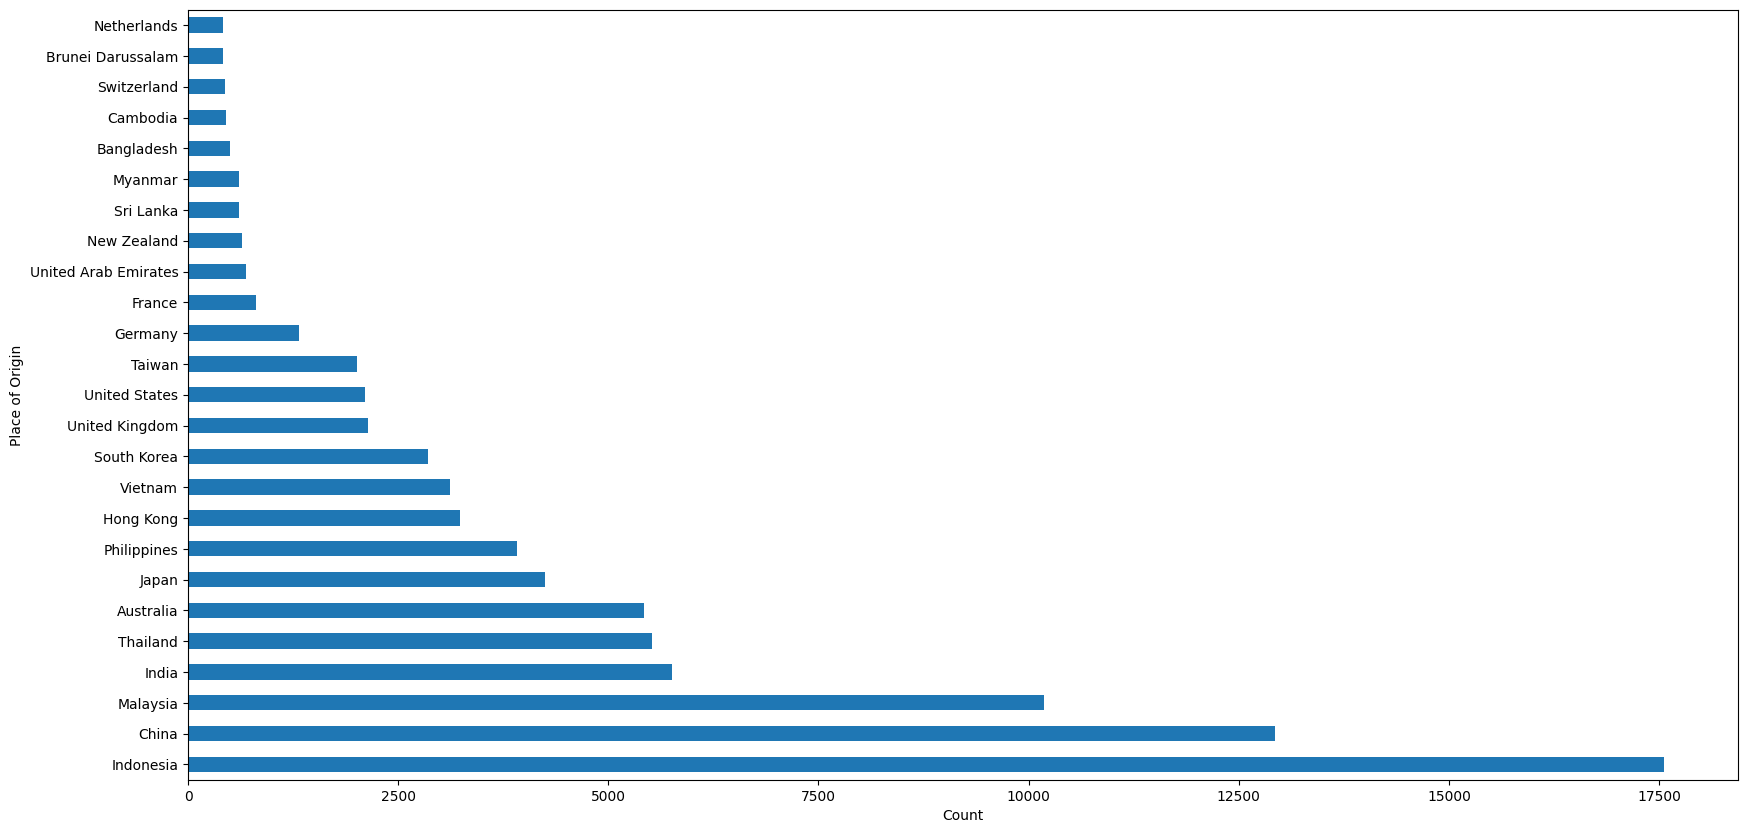

In [15]:
# place of origin =
# - country before Singapore
# - country of residence if missing
# - nationality if missing

df['PLACE_OF_ORIGIN'] = df['b7a'].astype('Int64').astype(str).map(label_map['b7a'])
print(f"% MISSING (before imputation): {df['PLACE_OF_ORIGIN'].isnull().mean()*100:.2f}%")
df['PLACE_OF_ORIGIN'] = df['PLACE_OF_ORIGIN'].fillna(df['COUNTRY_OF_RESIDENCE']).fillna(df['NATIONALITY'])
print(f"% MISSING (after imputation): {df['PLACE_OF_ORIGIN'].isnull().mean()*100:.2f}%")

ax = df['PLACE_OF_ORIGIN'].value_counts()\
                          .nlargest(25)\
                          .plot(kind = 'barh',
                                figsize = (20,10))
ax.set_ylabel("Place of Origin")
ax.set_xlabel("Count")

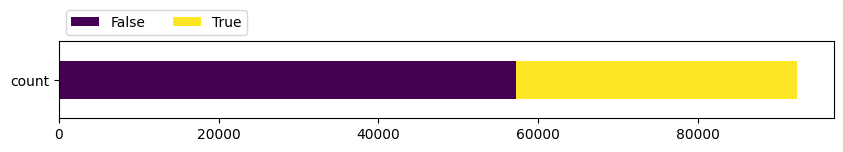

In [16]:
df['MULTICOUNTRY_TRIP'] = np.where(df['Country before SG'].isna() & df['Country after SG'].isna(), False, True)

StackedHorizontalBar(df, 'MULTICOUNTRY_TRIP')

% MISSING (before imputation): 73.05%


Text(0.5, 0, 'Count')

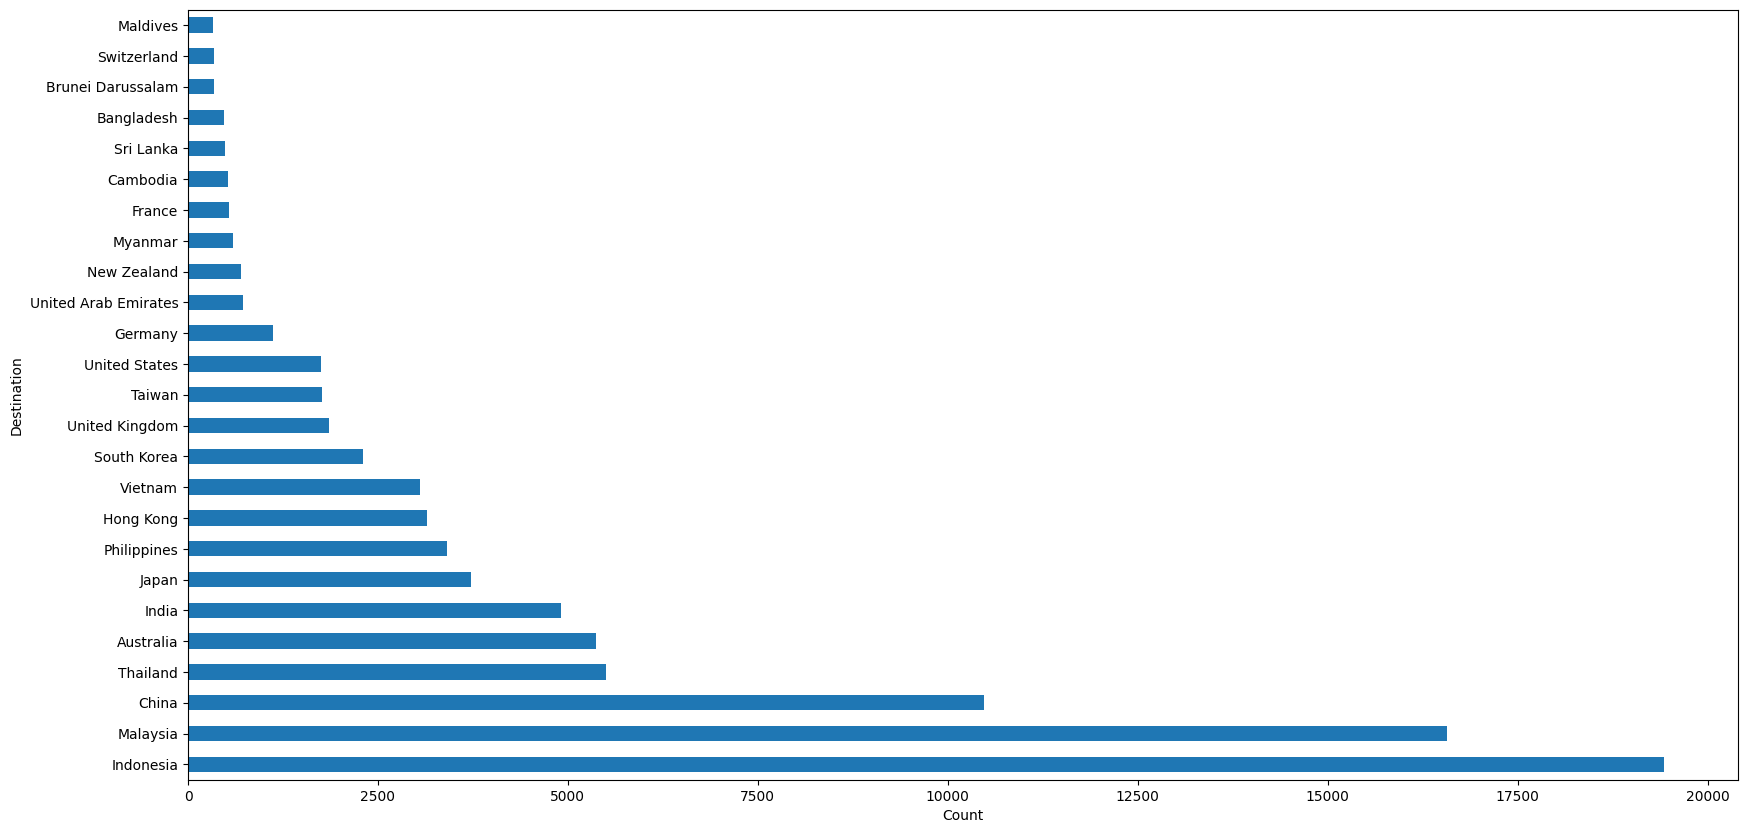

In [17]:
# destination = 
# - country after Singapore
# - country of residence if missing
# - nationality if missing

df['DESTINATION'] = df['b9a'].astype('Int64').astype(str).map(label_map['b9a'])
print(f"% MISSING (before imputation): {df['DESTINATION'].isnull().mean()*100:.2f}%")
df['DESTINATION'] = df['DESTINATION'].fillna(df['COUNTRY_OF_RESIDENCE']).fillna(df['NATIONALITY'])
print(f"% MISSING (after imputation): {df['DESTINATION'].isnull().mean()*100:.2f}%")

ax = df['DESTINATION'].value_counts()\
                      .nlargest(25)\
                      .plot(kind = 'barh',
                            figsize = (20,10))
ax.set_ylabel("Destination")
ax.set_xlabel("Count")

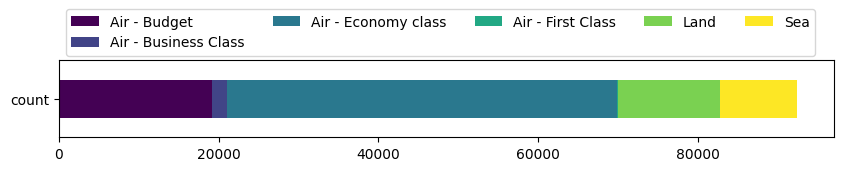

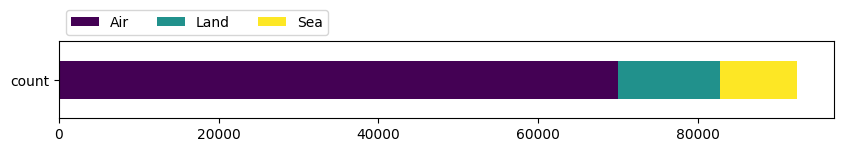

In [18]:
# mode of transport = passenger class x mode of departure

df['Class (Air)'] = df['b3b'].astype('Int64').astype(str).map(label_map['b3b']).apply(lambda x: "Air - " + str(x))
df['Class (Air)'] = df['Class (Air)'].replace("Air - nan", "Air - Economy class")

df['Class (Land)'] = df['b5'].astype('Int64').astype(str).map(label_map['b5']).apply(lambda x: "Land - " + str(x))
df['Class (Land)'] = df['Class (Land)'].replace("Land - nan", "Land")

df['MODE_OF_TRANSPORT'] = np.where(df['MODE_OF_DEPARTURE'] == 'Air', df['Class (Air)'],
                                   np.where(df['MODE_OF_DEPARTURE'] == 'Land', df['Class (Land)'], df['MODE_OF_DEPARTURE']))

StackedHorizontalBar(df, 'MODE_OF_TRANSPORT')
StackedHorizontalBar(df, 'MODE_OF_DEPARTURE')

df.drop('MODE_OF_DEPARTURE', axis=1, inplace=True)

In [19]:
# nights spent before/after Singapore

df['NIGHTS_BEFORE_SG'] = df['b7c'].astype('Int64')
df['NIGHTS_AFTER_SG'] = df['b9c'].astype('Int64')

# impute nights spent before Singapore with
# - 0 if not multicountry trip
# - mode when grouped by same place of origin, if data is available
# - mode of all filled values o/w

conditions = (df['MULTICOUNTRY_TRIP'] == False)
df.loc[conditions, 'NIGHTS_BEFORE_SG'] = df.loc[conditions, 'b7c'].fillna(0).astype('Int64')
modes = df.groupby('PLACE_OF_ORIGIN')['NIGHTS_BEFORE_SG'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
print(f"% MISSING (before mode imputation): {df['NIGHTS_BEFORE_SG'].isnull().mean()*100:.2f}%")
df['NIGHTS_BEFORE_SG'] = df['NIGHTS_BEFORE_SG'].fillna(modes)
overall_mode = df['NIGHTS_BEFORE_SG'][df['MULTICOUNTRY_TRIP'] == True].mode()[0]
print(f"% MISSING (after group mode imputation): {df['NIGHTS_BEFORE_SG'].isnull().mean()*100:.2f}%")
df['NIGHTS_BEFORE_SG'] = df['NIGHTS_BEFORE_SG'].fillna(overall_mode).astype('Int64')
print(f"% MISSING (after overall mode imputation): {df['NIGHTS_BEFORE_SG'].isnull().mean()*100:.2f}%")

# impute nights spent after Singapore with
# - 0 if not multicountry trip
# - mode when grouped by same destination, if data is available
# - mode of all filled values o/w

conditions = (df['MULTICOUNTRY_TRIP'] == False)
df.loc[conditions, 'NIGHTS_AFTER_SG'] = df.loc[conditions, 'b9c'].fillna(0).astype('Int64')
modes = df.groupby('DESTINATION')['NIGHTS_AFTER_SG'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
print(f"% MISSING (before mode imputation): {df['NIGHTS_AFTER_SG'].isnull().mean()*100:.2f}%")
df['NIGHTS_AFTER_SG'] = df['NIGHTS_AFTER_SG'].fillna(modes)
overall_mode = df['NIGHTS_AFTER_SG'][df['MULTICOUNTRY_TRIP'] == True].mode()[0]
print(f"% MISSING (after group mode imputation): {df['NIGHTS_AFTER_SG'].isnull().mean()*100:.2f}%")
df['NIGHTS_AFTER_SG'] = df['NIGHTS_AFTER_SG'].fillna(overall_mode).astype('Int64')
print(f"% MISSING (after overall mode imputation): {df['NIGHTS_AFTER_SG'].isnull().mean()*100:.2f}%")

% MISSING (before mode imputation): 21.21%
% MISSING (after mode imputation): 0.05%
% MISSING: 0.00%
% MISSING (before mode imputation): 11.48%
% MISSING (after mode imputation): 0.02%
% MISSING: 0.00%


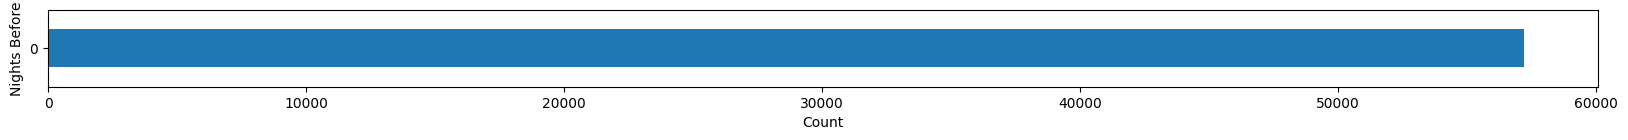

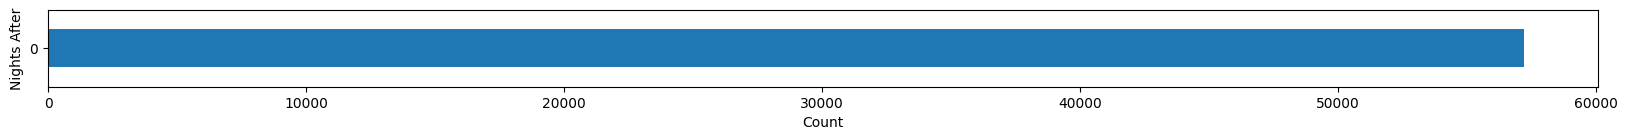

In [20]:
# edge case: nights spent before/after but not multicountry trip

ax = df['NIGHTS_BEFORE_SG'][df['MULTICOUNTRY_TRIP'] == False].value_counts()\
                      .nlargest(25)\
                      .plot(kind = 'barh',
                            figsize = (20,1))
ax.set_ylabel("Nights Before")
ax.set_xlabel("Count")
plt.show()

ax = df['NIGHTS_AFTER_SG'][df['MULTICOUNTRY_TRIP'] == False].value_counts()\
                      .nlargest(25)\
                      .plot(kind = 'barh',
                            figsize = (20,1))
ax.set_ylabel("Nights After")
ax.set_xlabel("Count")
plt.show()

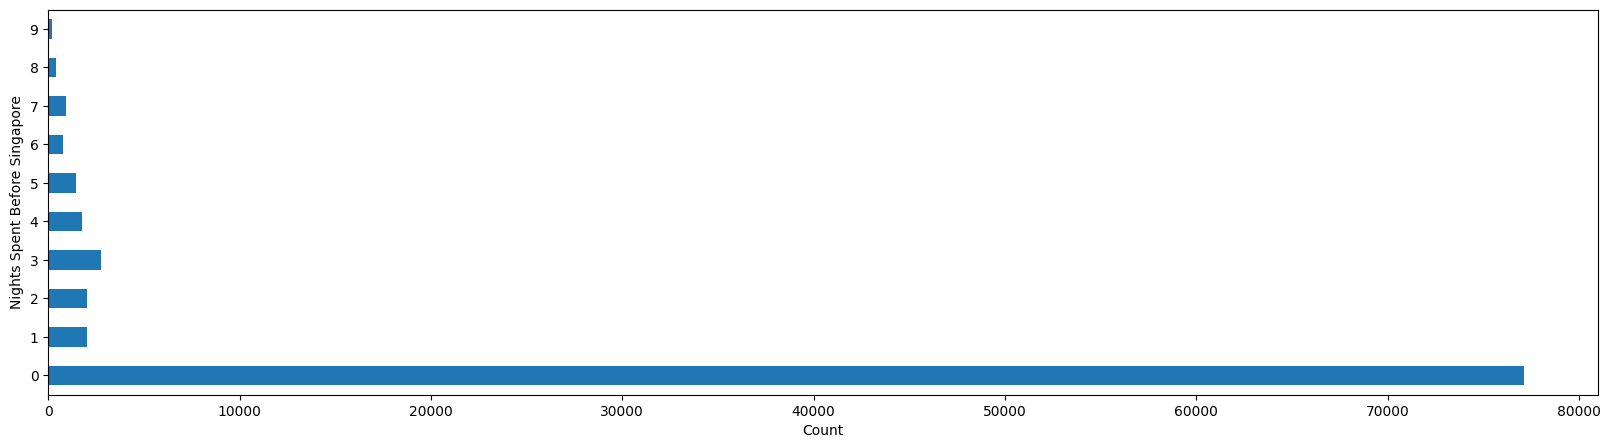

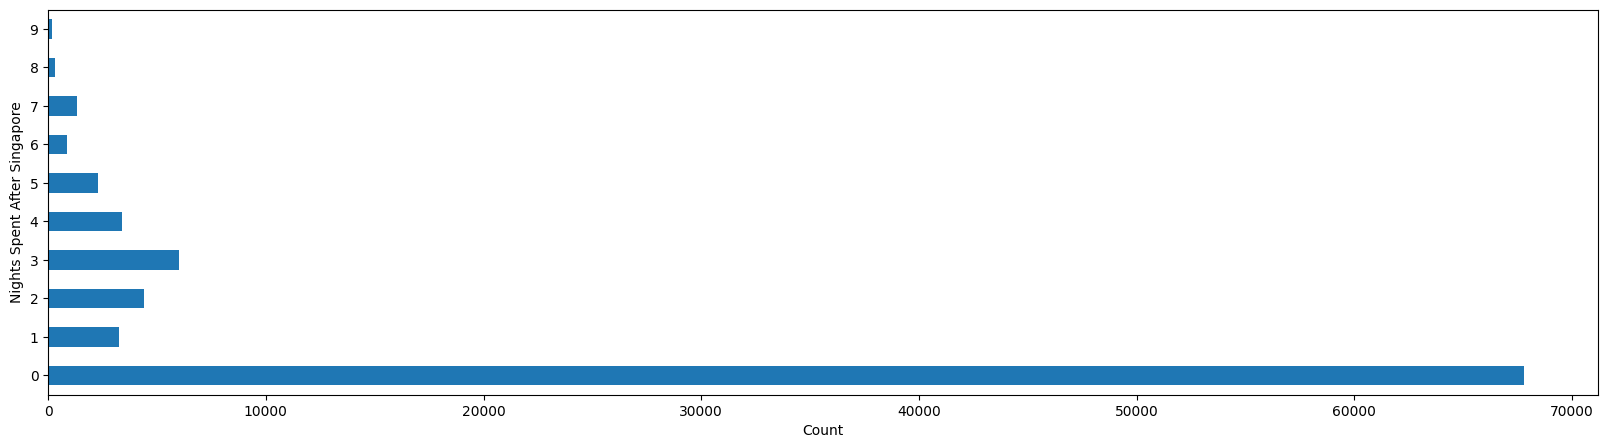

In [21]:
ax = df['NIGHTS_BEFORE_SG'].value_counts()\
                           .sort_index()\
                           .head(10)\
                           .plot(kind = 'barh',
                                figsize = (20,5))
ax.set_ylabel("Nights Spent Before Singapore")
ax.set_xlabel("Count")
plt.show()

ax = df['NIGHTS_AFTER_SG'].value_counts()\
                          .sort_index()\
                          .head(10)\
                          .plot(kind = 'barh',
                                figsize = (20,5))
ax.set_ylabel("Nights Spent After Singapore")
ax.set_xlabel("Count")
plt.show()

Text(0.5, 0, 'Count')

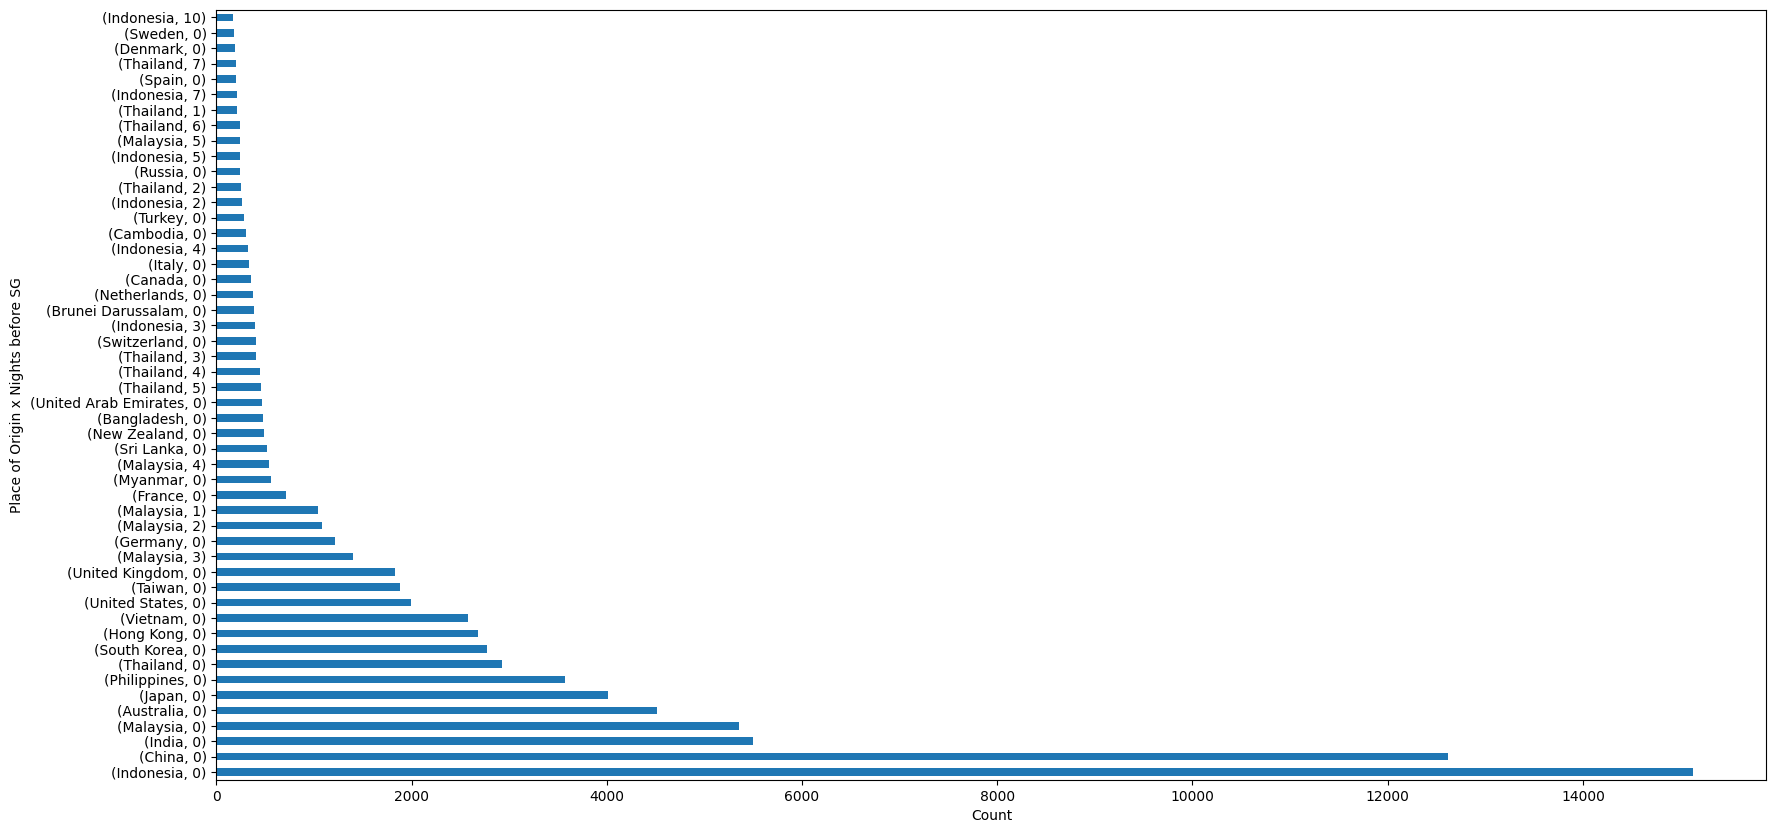

In [22]:
ax = df[['PLACE_OF_ORIGIN','NIGHTS_BEFORE_SG']].groupby('PLACE_OF_ORIGIN')\
                                               .value_counts()\
                                               .sort_index()\
                                               .nlargest(50)\
                                               .plot(kind = 'barh',
                                                     figsize = (20,10))
ax.set_ylabel("Place of Origin x Nights before SG")
ax.set_xlabel("Count")

Text(0.5, 0, 'Count')

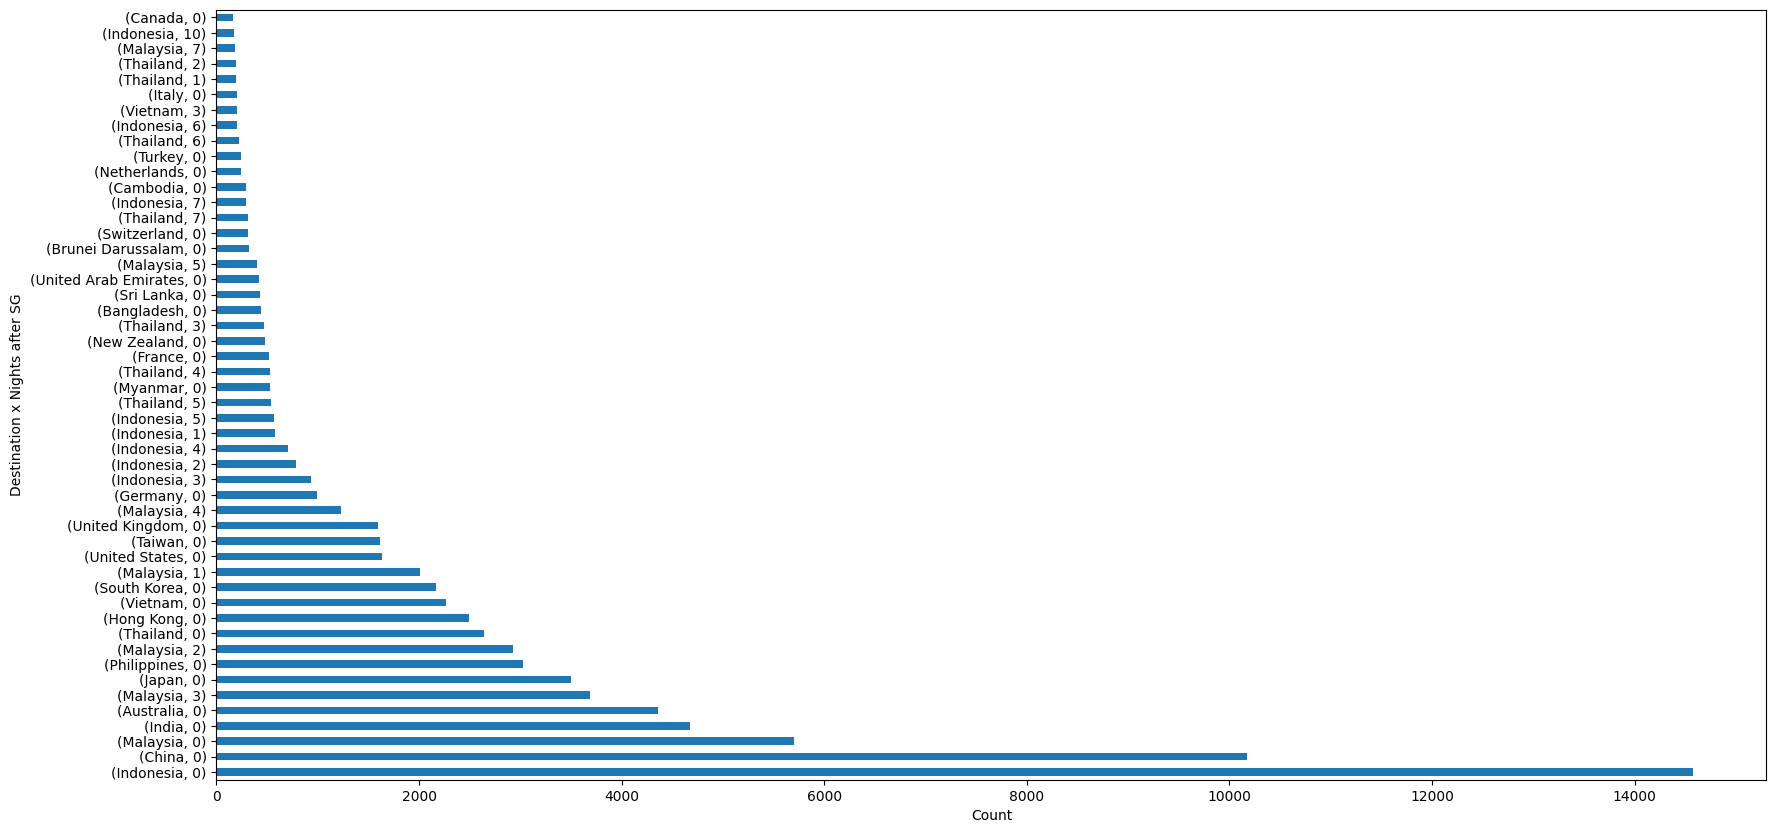

In [23]:
ax = df[['DESTINATION','NIGHTS_AFTER_SG']].groupby('DESTINATION')\
                                          .value_counts()\
                                          .nlargest(50)\
                                          .plot(kind = 'barh',
                                                figsize = (20,10))
ax.set_ylabel("Destination x Nights after SG")
ax.set_xlabel("Count")

In [24]:
# travel companion(s)

# includes spouse
df['TRAVEL_COMPANION=SPOUSE'] = df['b12_2'].astype('Int64').fillna(0)

# includes partner
df['TRAVEL_COMPANION=PARTNER'] = df['b12_3'].astype('Int64').fillna(0)

# number of parents
df['N(Parents)'] = df['b12number_2'].astype('Int64').fillna(0)

# number of grandparents
df['N(Grandparents)'] = df['b12number_3'].astype('Int64').fillna(0)

# number of siblings
df['N(Siblings)'] = df['b12number_4'].astype('Int64').fillna(0)

# number of other relatives
df['N(Other Relatives)'] = df['b12number_5'].astype('Int64').fillna(0)

# number of friends
df['N(Friends)'] = df['b12number_6'].astype('Int64').fillna(0)

# number of other companions
df['N(Others)'] = df[['b12number_7', 'b12number_8', 'b12number_9']].sum(axis=1, skipna=True).astype('Int64').fillna(0)

# number of children
df['N(Children)'] = df['b12number_2'].astype('Int64').fillna(0)

# boolean for child(ren) in 0-12, 13-19 age band
df['BOOL_CHILD_0to12Years'] = np.where(df['b12b_1'].astype('Int64').fillna(0) > 0, True, False)
df['BOOL_CHILD_13to19Years'] = np.where(df['b12b_2'].astype('Int64').fillna(0) > 0, True, False)

total_companions = [
    'TRAVEL_COMPANION=SPOUSE',
    'TRAVEL_COMPANION=PARTNER',
    'N(Parents)',
    'N(Grandparents)',
    'N(Siblings)',
    'N(Other Relatives)',
    'N(Friends)',
    'N(Others)',
    'N(Children)'
]
n_pax = df[total_companions].sum(axis=1) + 1
df['N_PAX'] = df['c5'].fillna(n_pax)

Travel with spouse


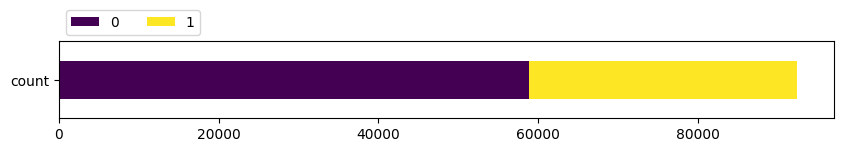

Travel with partner


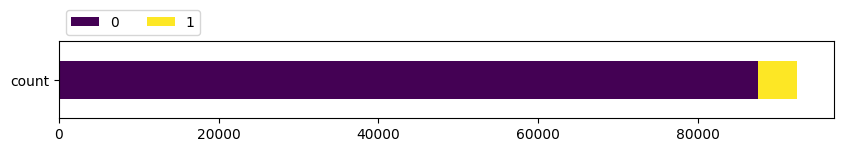

Travel with child 0-12 years


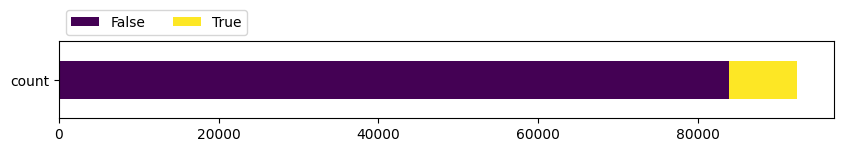

Travel with child 13-19 years


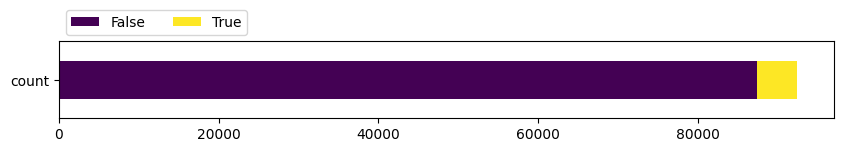

In [25]:
print("Travel with spouse")
StackedHorizontalBar(df, 'TRAVEL_COMPANION=SPOUSE')
print("Travel with partner")
StackedHorizontalBar(df, 'TRAVEL_COMPANION=PARTNER')
print("Travel with child 0-12 years")
StackedHorizontalBar(df, 'BOOL_CHILD_0to12Years')
print("Travel with child 13-19 years")
StackedHorizontalBar(df, 'BOOL_CHILD_13to19Years')

In [26]:
# boolean for parents
df['BOOL_PARENTS'] = np.where(df['b12number_2'].astype('Int64').fillna(0) > 0, True, False)

# boolean for grandparents
df['BOOL_GRANDPARENTS'] = np.where(df['b12number_3'].astype('Int64').fillna(0) > 0, True, False)

# boolean for siblings
df['BOOL_SIBLINGS'] = np.where(df['b12number_4'].astype('Int64').fillna(0) > 0, True, False)

# boolean for friends
df['BOOL_FRIENDS'] = np.where(df['b12number_6'].astype('Int64').fillna(0) > 0, True, False)

Travel with parents


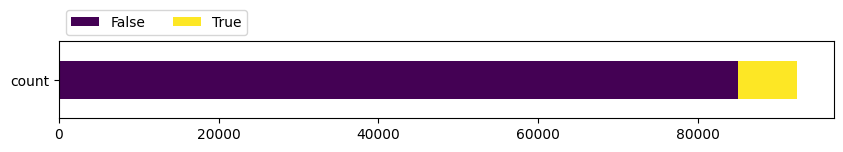

Travel with grandparents


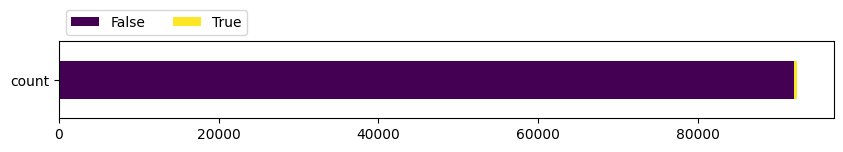

Travel with siblings


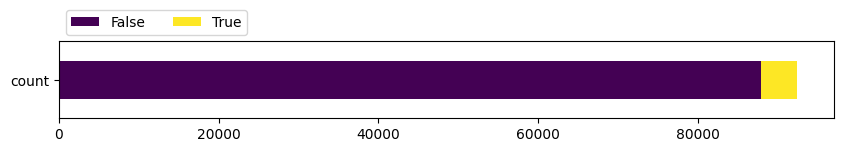

Travel with friends


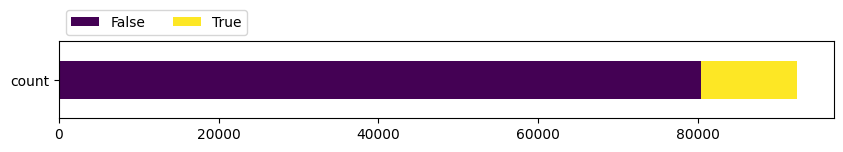

In [27]:
print("Travel with parents")
StackedHorizontalBar(df, 'BOOL_PARENTS')
print("Travel with grandparents")
StackedHorizontalBar(df, 'BOOL_GRANDPARENTS')
print("Travel with siblings")
StackedHorizontalBar(df, 'BOOL_SIBLINGS')
print("Travel with friends")
StackedHorizontalBar(df, 'BOOL_FRIENDS')

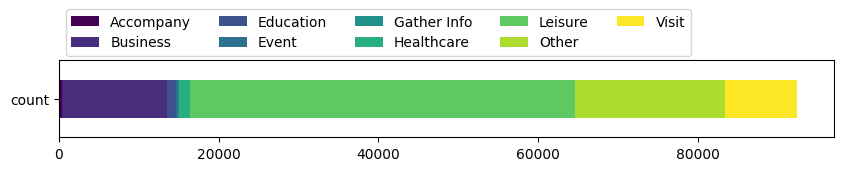

In [28]:
# main purpose of visit

pov_map = {
    'b13a_111': 'Event',
    'b13a_112': 'Leisure',
    'b13a_113': 'Accompany',
    'b13a_114': 'Visit',
    'b13a_115': 'Gather Info',
    'b13a_116': 'Business',
    'b13a_117': 'Healthcare',
    'b13a_118': 'Education',
    'b13a_119': 'Other'
}

def MainPOV(row):
    columns = list(pov_map.keys())
    active_columns = [col for col in columns if row[col] == 1]
    if len(active_columns) == 1:
        return pov_map[active_columns[0]]
    else:
        return 'Other'
    
df['MAIN_POV'] = df.apply(MainPOV, axis=1)

StackedHorizontalBar(df, 'MAIN_POV')

POV = (Leisure) Cruise


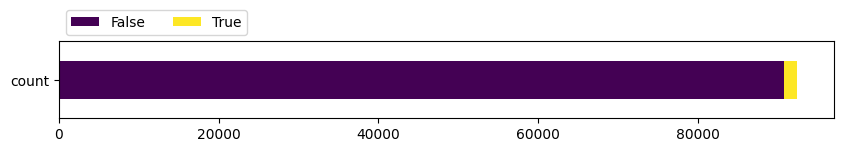

POV = (Business) Meeting


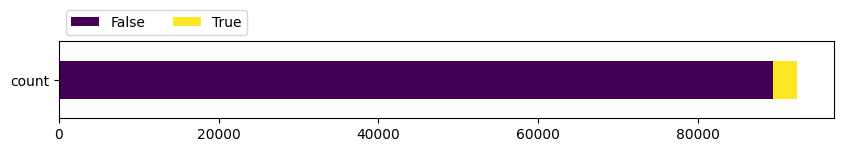

POV = (Event) Cultural Festival


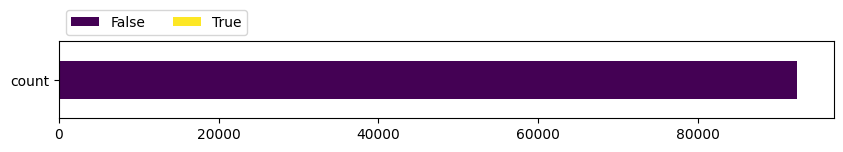

POV = (Other) Job Opportunities


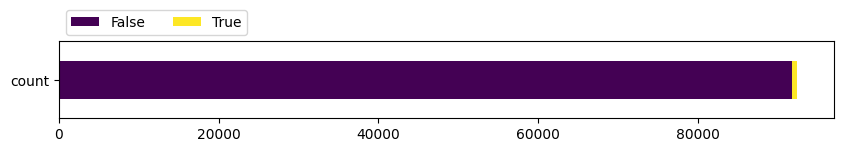

POV = (Business) General


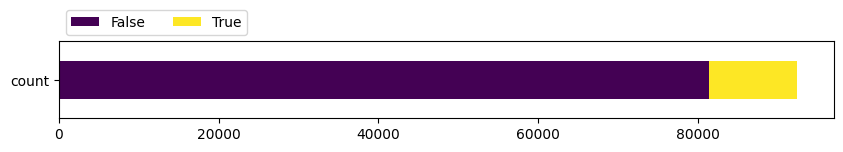

POV = (Other) Singapore as an Overnight Layover


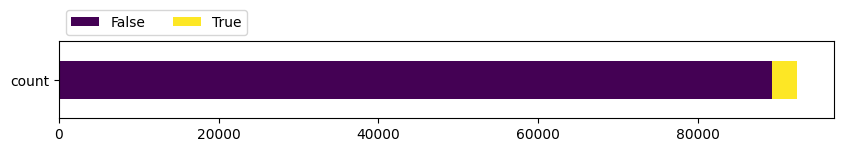

POV = (Leisure) Sightseeing


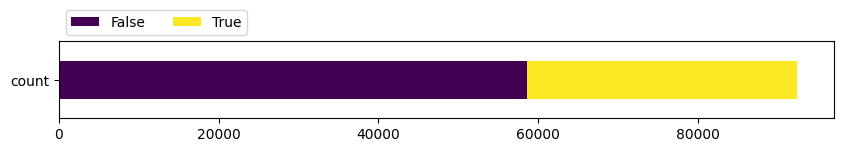

POV = (Leisure) Shopping


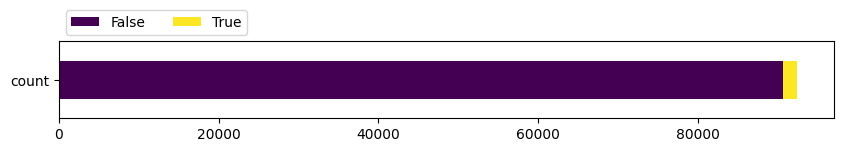

POV = (Other) Visa / Permit-related


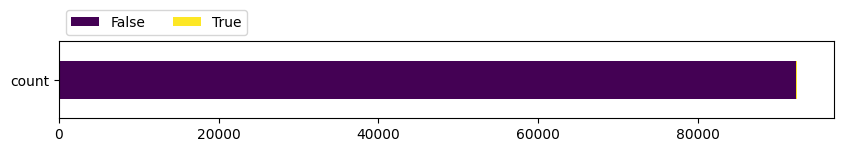

POV = (Visit) International Student


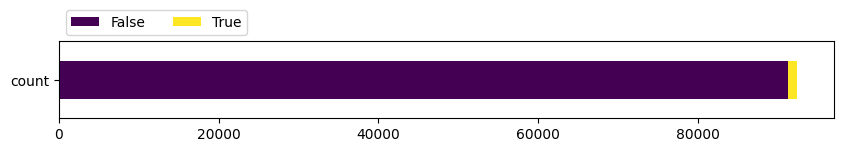

POV = (Other) Other


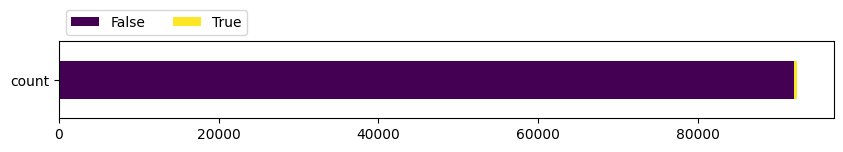

POV = (Event) Performing Arts


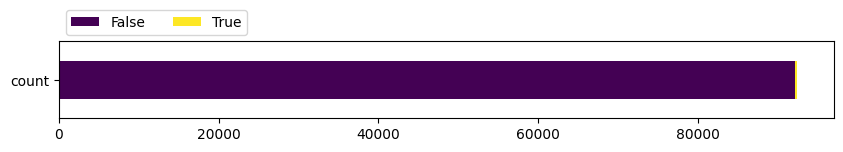

POV = (Gather Info) Education


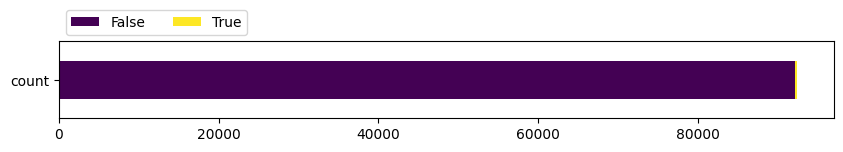

POV = (Gather Info) Other


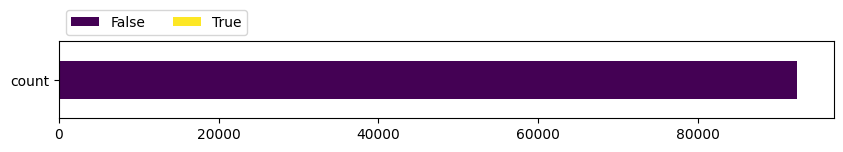

POV = (Leisure) Other


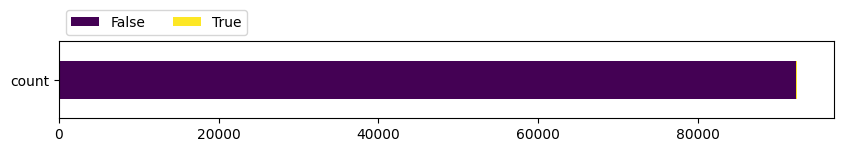

POV = (Leisure) Nightlife


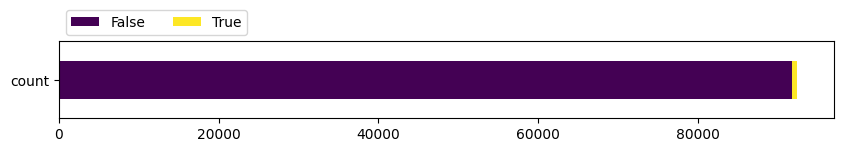

POV = (Leisure) Food


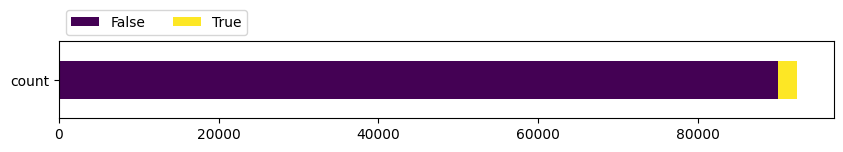

POV = (Business) Convention / Conference


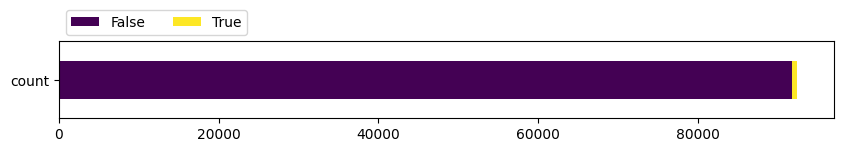

POV = (Event) Other


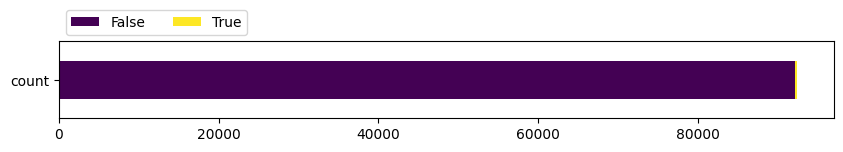

POV = (Event) Sporting


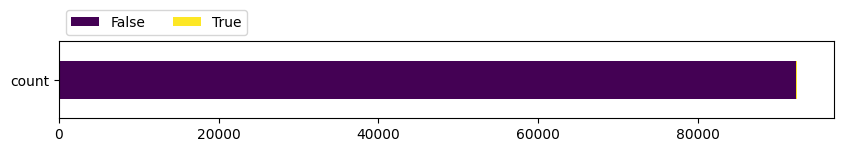

POV = (Leisure) Rest & Relax


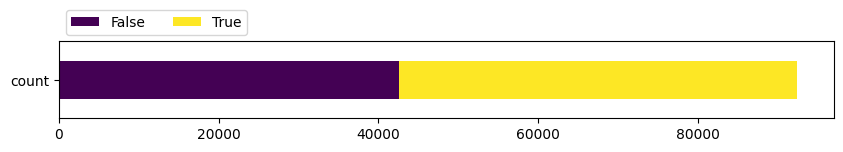

POV = (Gather Info) Healthcare


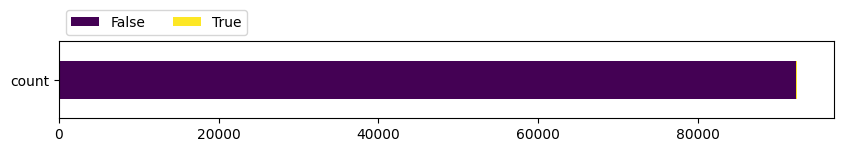

POV = (Leisure) Experience Cultures


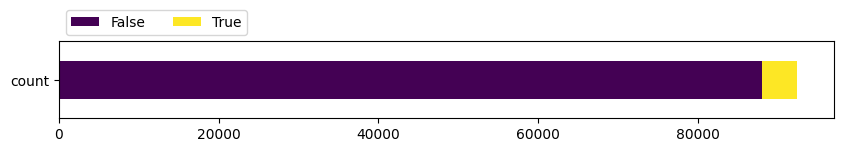

POV = (Leisure) Integrated Resorts


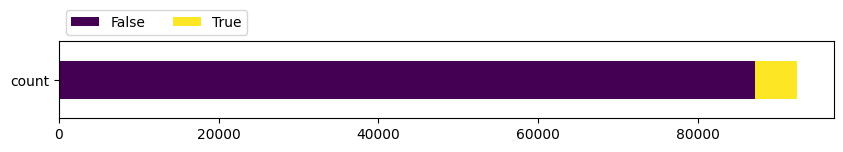

POV = (Business) Exhibition / Trade Show


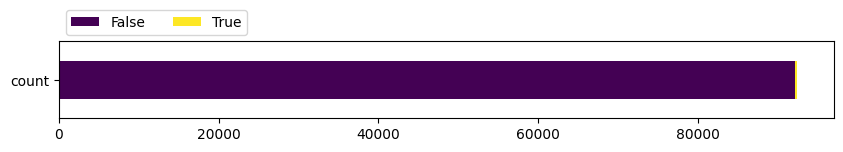

POV = (Visit) Locals


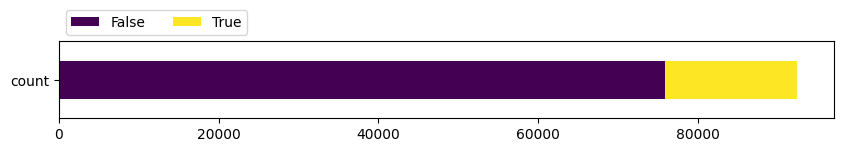

In [29]:
# map purpose of visit subcategory

# drop (Other) Singapore as a Non-overnight Layover
# downcast all Education-related POV to Education
# downcast all Healthcare-related POV to Healthcare
# merge (Business) Sponsored Holiday and (Business) Other into (Business) General
# merge (Event) Performing Arts and (Event) Music-related into (Event) Performing Arts
# merge (Event) Family Entertainment and (Event) Party into (Event) Other
# downcast all Accompany-related to Accompany
# downcast all Gather Info-related to Gather Info

from collections import defaultdict

subpov_map = {
    'b13b_1': 'POV = (Event) Other',
    'b13b_2': 'POV = (Event) Performing Arts',
    'b13b_3': 'POV = (Event) Sporting',
    'b13b_4': 'POV = (Event) Performing Arts',
    'b13b_5': 'POV = (Event) Cultural Festival',
    'b13b_6': 'POV = (Event) Other',
    'b13b_7': 'POV = (Event) Other',
    'b13b_8': 'POV = (Leisure) Food',
    'b13b_9': 'POV = (Leisure) Nightlife',
    'b13b_10': 'POV = (Leisure) Shopping',
    'b13b_11': 'POV = (Leisure) Experience Cultures',
    'b13b_12': 'POV = (Leisure) Cruise',
    'b13b_13': 'POV = (Leisure) Sightseeing',
    'b13b_14': 'POV = (Leisure) Rest & Relax',
    'b13b_15': 'POV = (Leisure) Integrated Resorts',
    'b13b_771': 'POV = (Leisure) Other',
    #'b13b_21': 'POV = (Accompany) Business Visitor',
    #'b13b_22': 'POV = (Accompany) Outpatient Consultation / Treatment',
    #'b13b_23': 'POV = (Accompany) Day Surgery',
    #'b13b_24': 'POV = (Accompany) Inpatient Consultation / Treatment',
    #'b13b_25': 'POV = (Accompany) International Student',
    #'b13b_772': 'POV = (Accompany) Other',
    'b13b_31': 'POV = (Visit) Locals',
    'b13b_32': 'POV = (Visit) International Student',
    #'b13b_33': 'POV = (Gather Info) Healthcare',
    #'b13b_34': 'POV = (Gather Info) Education',
    #'b13b_773': 'POV = (Gather Info) Other',
    'b13b_41': 'POV = (Business) Meeting',
    'b13b_42': 'POV = (Business) General',
    'b13b_43': 'POV = (Business) Convention / Conference',
    'b13b_44': 'POV = (Business) Exhibition / Trade Show',
    'b13b_45': 'POV = (Business) General',
    'b13b_774': 'POV = (Business) General',
    #'b13b_51': 'POV = (Healthcare) Outpatient Consultation / Treatment',
    #'b13b_52': 'POV = (Healthcare) Day Surgery',
    #'b13b_53': 'POV = (Healthcare) Inpatient Consultation / Treatment',
    #'b13b_775': 'POV = (Healthcare) Other',
    #'b13b_61': 'POV = (Education) Company Training',
    #'b13b_62': 'POV = (Education) Executive Training',
    #'b13b_63': 'POV = (Education) Study Mission',
    #'b13b_64': 'POV = (Education) Skills Development',
    #'b13b_65': 'POV = (Education) Personal Enrichment',
    #'b13b_66': 'POV = (Education) School Trip',
    #'b13b_67': 'POV = (Education) Student Event',
    #'b13b_68': 'POV = (Education) Student Enrichment',
    #'b13b_776': 'POV = (Education) Other',
    #'b13b_120': 'POV = (Other) Singapore as a Non-overnight Layover',
    'b13b_121': 'POV = (Other) Singapore as an Overnight Layover',
    'b13b_122': 'POV = (Other) Job Opportunities',
    'b13b_124': 'POV = (Other) Visa / Permit-related',
    'b13b_996': 'POV = (Other) Other'
}

new_columns_map = defaultdict(list)
for old_col, new_col in subpov_map.items():
    new_columns_map[new_col].append(old_col)
    
for new_col, old_cols in new_columns_map.items():
    df[new_col] = df[old_cols].any(axis = 1)
    
df.drop(columns = [col for col_list in new_columns_map.values() for col in col_list], inplace = True)

for col in set(list(subpov_map.values())):
    print(col)
    StackedHorizontalBar(df, col)

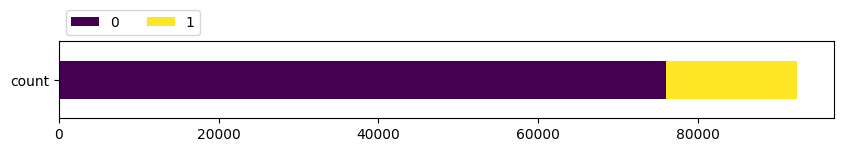

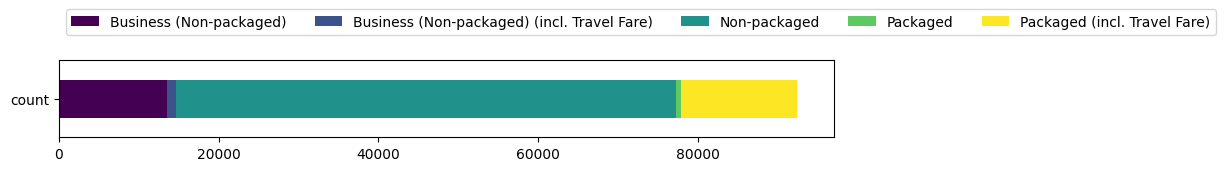

In [30]:
# purchased travel package

df['TRAVEL_PACKAGE'] = df['c1a'].fillna(0)
df['Package Type'] = df['tr.type'].fillna("").astype(str).map(label_map['tr.type'])
StackedHorizontalBar(df, 'TRAVEL_PACKAGE')

# package type = travel type x inclusion of travel fare

def PackageType(row):
    tr_type = row['Package Type']
    if row['Package Type']:
        if row['c2'] == 1:
            fare_type = " (incl. Travel Fare)"
        else:
            fare_type = ""
    return f"{tr_type}{fare_type}"

df['PACKAGE_TYPE'] = df.apply(PackageType, axis=1)
df['PACKAGE_TYPE'] = df['PACKAGE_TYPE'].astype(str)
StackedHorizontalBar(df, 'PACKAGE_TYPE')

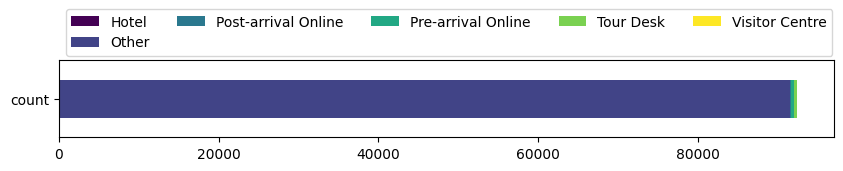

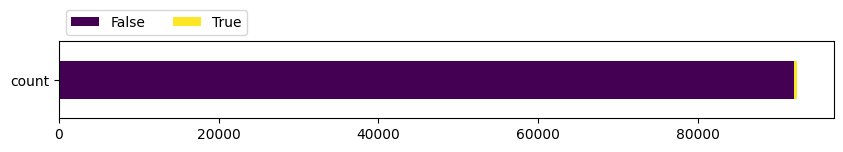

In [31]:
# tour purchase method

method_map = {
    'c8ii_1': 'Pre-arrival Online',
    'c8ii_2': 'Post-arrival Online',
    'c8ii_4': 'Tour Desk',
    'c8ii_5': 'Hotel',
    'c8ii_6': 'Visitor Centre'
}

def PurchaseMethod(row):
    columns = list(method_map.keys())
    active_columns = [col for col in columns if row[col] == 1]
    if len(active_columns) == 1:
        return method_map[active_columns[0]]
    else:
        return 'Other'
    
df['PACKAGE_PURCHASE_METHOD'] = df.apply(PurchaseMethod, axis=1)

StackedHorizontalBar(df, 'PACKAGE_PURCHASE_METHOD')

new_map = {
    'Pre-arrival Online': True,
    'Post-arrival Online': False,
    'Tour Desk': False,
    'Hotel': False,
    'Visitor Centre': False,
    'Other': False
}

df['PRE-ARRIVAL_PACKAGE'] = df['PACKAGE_PURCHASE_METHOD'].map(new_map)

StackedHorizontalBar(df, 'PRE-ARRIVAL_PACKAGE')

df.drop('PACKAGE_PURCHASE_METHOD', axis=1, inplace=True)

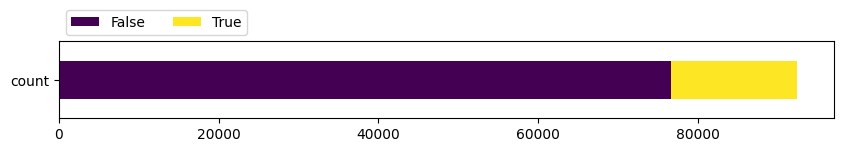

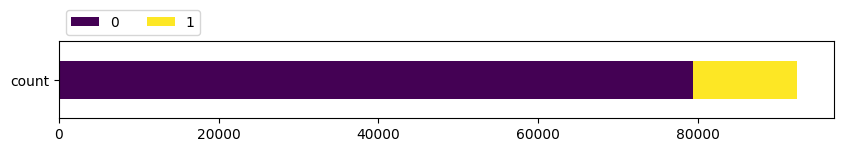

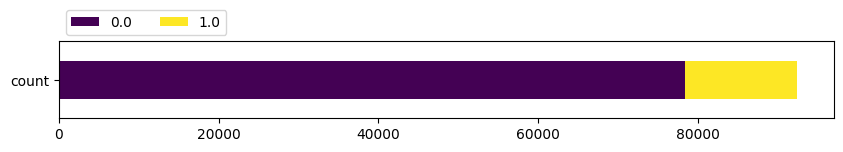

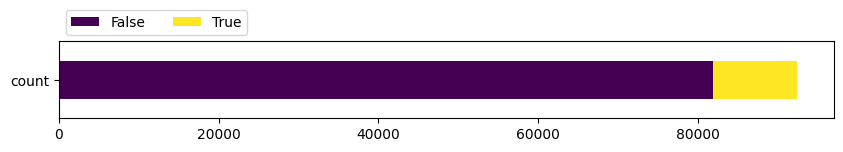

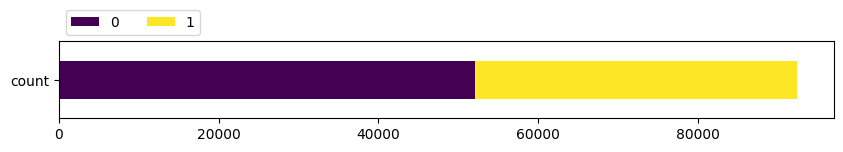

In [32]:
# package inclusions

# accommodation
# - not in package unless declared

df['ACCOMMODATION_IN_PACKAGE'] = df['c1c'].fillna(0)
df['ACCOMMODATION_IN_PACKAGE'] = df['ACCOMMODATION_IN_PACKAGE'] >= 1
StackedHorizontalBar(df, 'ACCOMMODATION_IN_PACKAGE')

# food & beverages
# - not in package unless declared

df['F&B_IN_PACKAGE'] = df['c6_1'].fillna(0)
StackedHorizontalBar(df, 'F&B_IN_PACKAGE')

# transportation
# - not in package unless declared

df['TRANSPORT_IN_PACKAGE'] = df['c7a_1'].fillna(0)
StackedHorizontalBar(df, 'TRANSPORT_IN_PACKAGE')

# sightseeing & entertainment
# - not in package unless declared

se_cats = ['c10b_1_1', 'c10b_2_1', 'c10b_3_1', 'c10b_4_1']
df[se_cats] = df[se_cats].fillna(0)
df['S&E_IN_PACKAGE'] = df[se_cats].sum(axis = 1)
df['S&E_IN_PACKAGE'] = df['S&E_IN_PACKAGE'] >= 1
df = df.drop(columns = se_cats)
StackedHorizontalBar(df, 'S&E_IN_PACKAGE')

# friends/family in Singapore
# - no unless declared

df['FRIENDS_FAMILY_IN_SG'] = df['c9'].fillna(0)
StackedHorizontalBar(df, 'FRIENDS_FAMILY_IN_SG')

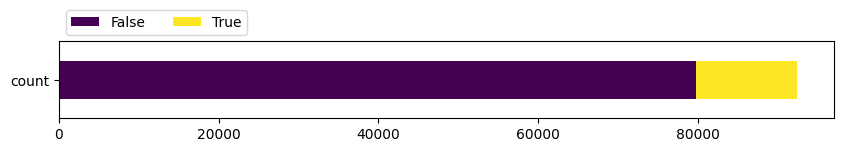

In [33]:
# GST claim

df['GST_CLAIM'] = df['c17'].fillna(0)
df['GST_CLAIM'] = df['GST_CLAIM'] >= 1

StackedHorizontalBar(df, 'GST_CLAIM')

array([[<Axes: title={'center': '$_ACCOMMODATION_TOTAL'}, xlabel='TRAVEL_PACKAGE'>,
        <Axes: title={'center': '$_F&B_TOTAL'}, xlabel='TRAVEL_PACKAGE'>],
       [<Axes: title={'center': '$_TRANSPORT_TOTAL'}, xlabel='TRAVEL_PACKAGE'>,
        <Axes: title={'center': '$_S&E_TOTAL'}, xlabel='TRAVEL_PACKAGE'>],
       [<Axes: title={'center': '$_SHOPPING_TOTAL'}, xlabel='TRAVEL_PACKAGE'>,
        <Axes: >]], dtype=object)

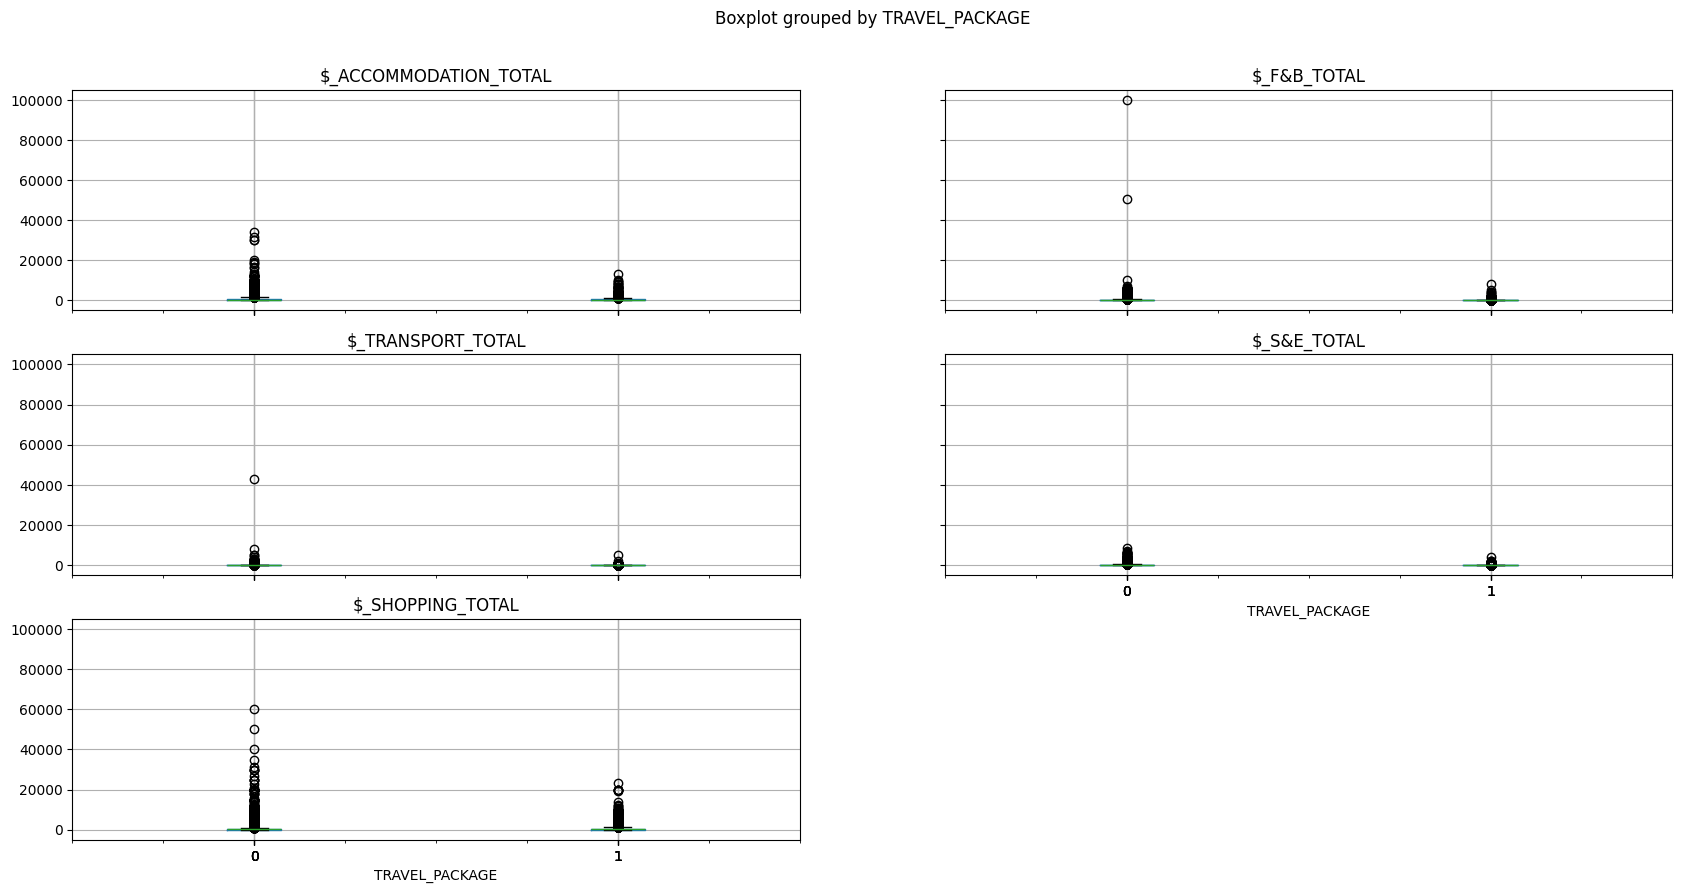

In [34]:
# totals by spend component

df['$_ACCOMMODATION_TOTAL'] = df['c4.tot'].fillna(df[['c4d_1.r','c4d_2.r','c4d_3.r','c4d_4.r','c4d_5.r','c4d_6.r','c4d_7.r','c4d_8.r']].sum(axis=1))
df['$_F&B_TOTAL'] = df['c6.tot'].fillna(df[['c6c_1.r','c6c_2.r','c6c_3.r','c6c_4.r']].sum(axis=1))
df['$_TRANSPORT_TOTAL'] = df['c7.tot'].fillna(df[['c7b_1.r','c7b_2.r']].sum(axis=1))
df['$_S&E_TOTAL'] = df['c10.tot'].fillna(df[['c10c_1.r','c10c_2.r','c10c_3.r','c10c_4.r']].sum(axis=1))
df['$_SHOPPING_TOTAL'] = df['c14.r'].fillna(df[['c15_1.r','c15_2.r','c15_3.r','c15_4.r','c15_5.r','c15_6.r','c15_7.r','c15_8.r','c15_9.r','c15_10.r','c15_11.r','c15_12.r','c15_13.r','c15_14.r']].sum(axis=1))

spend_cols = [
    '$_ACCOMMODATION_TOTAL',
    '$_F&B_TOTAL',
    '$_TRANSPORT_TOTAL',
    '$_S&E_TOTAL',
    '$_SHOPPING_TOTAL'
]
df.boxplot(column = spend_cols,
           by = 'TRAVEL_PACKAGE',
           figsize = (20,10))  

In [35]:
# cost of travel package

df['$_PACKAGE_PER_PAX'] = df['c1b.r'].replace(0, np.nan).fillna(np.nan)
print(df['$_PACKAGE_PER_PAX'].describe())

# remove outlier individual
mean_price = df['$_PACKAGE_PER_PAX'].mean()
std_dev_price = df['$_PACKAGE_PER_PAX'].std()

count    1.371200e+04
mean     1.364658e+04
std      1.114156e+06
min      1.204000e-03
25%      7.257300e+02
50%      1.205390e+03
75%      2.300000e+03
max      1.297475e+08
Name: $_PACKAGE_PER_PAX, dtype: float64


In [ ]:
%%time

# perform KNN-based imputation for age band
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# select numerical features
numericals = ['MONTH_OF_ARRIVAL', 'MONTH_OF_DEPARTURE', 'LENGTH_OF_STAY',
              'INTERVIEW_IN_ENGLISH', 'MULTICOUNTRY_TRIP', 'NIGHTS_BEFORE_SG', 'NIGHTS_AFTER_SG',
              'TRAVEL_COMPANION=SPOUSE', 'TRAVEL_COMPANION=PARTNER',
              'BOOL_CHILD_0to12Years', 'BOOL_CHILD_13to19Years',
              'BOOL_PARENTS', 'BOOL_GRANDPARENTS', 'BOOL_SIBLINGS',
              'TRAVEL_PACKAGE', 'PRE-ARRIVAL_PACKAGE',
              'ACCOMMODATION_IN_PACKAGE', 'F&B_IN_PACKAGE', 'TRANSPORT_IN_PACKAGE', 'S&E_IN_PACKAGE',
              'GST_CLAIM', 'FRIENDS_FAMILY_IN_SG'] + list(set(list(subpov_map.values())))

numerical_df = df[numericals]

from sklearn.preprocessing import OneHotEncoder

categoricals = ['MODE_OF_ARRIVAL', 'NATIONALITY', 'COUNTRY_OF_RESIDENCE', 'PLACE_OF_ORIGIN', 'DESTINATION',
                'MODE_OF_TRANSPORT', 'MAIN_POV', 'PACKAGE_TYPE', 'TIME_SINCE_LAST_VISIT']

# select and one-hot encode categorical features
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(df[categoricals])
encoded_df = pd.DataFrame(encoded_data.toarray(),
                          columns = encoder.get_feature_names_out(categoricals))

# combine features for KNN
features = pd.concat([numerical_df.reset_index(drop = True), encoded_df], axis = 1)

# encode target (ensure NaN is retained)
label_encoder = LabelEncoder()
df['AGE_BAND'] = df['AGE_BAND'].fillna("MISSING")
df['AGE_BAND'] = df['AGE_BAND'].astype(str)
encoded_target = label_encoder.fit_transform(df['AGE_BAND'])
encoded_missing = label_encoder.transform(["MISSING"])[0]
encoded_target = encoded_target.astype(float)
encoded_target[encoded_target == encoded_missing] = np.nan
encoded_target = encoded_target.reshape(-1,1)

# perform imputation
all_data = features.copy()
all_data['AGE_BAND_encoded'] = encoded_target.ravel()
imputer = KNNImputer(n_neighbors = 5)
all_data_imputed = imputer.fit_transform(all_data)

# extract imputed age band and decode back to original labels
imputed_age = np.round(all_data_imputed[:, -1]).astype(int)
df['AGE_BAND'] = label_encoder.inverse_transform(imputed_age)

StackedHorizontalBar(df, 'AGE_BAND')

In [ ]:
df.to_csv('../data/IMPUTED_MASTER1.csv', index = False)

In [ ]:
%%time

# set aside all spend by package travelers as additional spend
df_A = df[df['TRAVEL_PACKAGE'] == 0]
df_B = df[df['TRAVEL_PACKAGE'] != 0]
df_B[spend_cols] = df_B[spend_cols].fillna(0)

sum_components = df_A[spend_cols].sum(axis=1)

global_ratios = {
    'Accommodation': (df_A['$_ACCOMMODATION_TOTAL']/sum_components).mean(),
    'F&B': (df_A['$_F&B_TOTAL']/sum_components).mean(),
    'Transport': (df_A['$_TRANSPORT_TOTAL']/sum_components).mean(),
    'S&E': (df_A['$_S&E_TOTAL']/sum_components).mean(),
    'Shopping': (df_A['$_SHOPPING_TOTAL']/sum_components).mean()
}

df_C = df_B.copy()
df_C.loc[:, spend_cols] = np.nan

# re-merge to perform imputation
merged_df = pd.concat([df_A, df_C])

# impute each spend component of package spenders with KNN-based imputation using non-spend, non-package columns
numericals = ['MONTH_OF_ARRIVAL', 'MONTH_OF_DEPARTURE', 'LENGTH_OF_STAY',
              'INTERVIEW_IN_ENGLISH', 'MULTICOUNTRY_TRIP', 'NIGHTS_BEFORE_SG', 'NIGHTS_AFTER_SG',
              'TRAVEL_COMPANION=SPOUSE', 'TRAVEL_COMPANION=PARTNER',
              'BOOL_CHILD_0to12Years', 'BOOL_CHILD_13to19Years',
              'BOOL_PARENTS', 'BOOL_GRANDPARENTS', 'BOOL_SIBLINGS',
              #'TRAVEL_PACKAGE', 'PRE-ARRIVAL_PACKAGE',
              #'ACCOMMODATION_IN_PACKAGE', 'F&B_IN_PACKAGE', 'TRANSPORT_IN_PACKAGE', 'S&E_IN_PACKAGE',
              'GST_CLAIM', 'FRIENDS_FAMILY_IN_SG'] + list(set(list(subpov_map.values()))) + spend_cols

numerical_df = merged_df[numericals]

categoricals = ['MODE_OF_ARRIVAL', 'NATIONALITY', 'COUNTRY_OF_RESIDENCE', 'PLACE_OF_ORIGIN', 'DESTINATION',
                'MODE_OF_TRANSPORT', 'MAIN_POV', 'TIME_SINCE_LAST_VISIT']

encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(merged_df[categoricals])
encoded_df = pd.DataFrame(encoded_data.toarray(),
                          columns = encoder.get_feature_names_out(categoricals))

features = pd.concat([numerical_df.reset_index(drop = True), encoded_df], axis = 1)

all_data = features.copy()
imputer = KNNImputer(n_neighbors = 5)
all_data_imputed = imputer.fit_transform(all_data)
imputed_df = pd.DataFrame(all_data_imputed, columns = features.columns)

# ensure sum of total spend <= total package spend (N_TOTAL_COMPANIONS * $_PACKAGE_PER_PAX)
for index in df_B.index:
    sum_spend = imputed_df.loc[index,:][spend_cols].sum()
    package_spend = df_B.loc[index,'$_PACKAGE_PER_PAX'] * df_B.loc[index,'N_PAX']
    
    # if not, remove difference by global ratio of spend in each component
    if not np.isnan(package_spend) and sum_spend > package_spend:
        difference = package_spend - sum_spend
        imputed_df.loc[index, '$_ACCOMMODATION_TOTAL'] -= global_ratios['Accommodation']*difference
        imputed_df.loc[index, '$_F&B_TOTAL'] -= global_ratios['F&B']*difference
        imputed_df.loc[index, '$_TRANSPORT_TOTAL'] -= global_ratios['Transport']*difference
        imputed_df.loc[index, '$_S&E_TOTAL'] -= global_ratios['S&E']*difference
        imputed_df.loc[index, '$_SHOPPING_TOTAL'] -= global_ratios['Shopping']*difference
    
    # add additional spend
    imputed_df.loc[index, '$_ACCOMMODATION_TOTAL'] += df_B.loc[index, '$_ACCOMMODATION_TOTAL']
    imputed_df.loc[index, '$_F&B_TOTAL'] += df_B.loc[index, '$_F&B_TOTAL']
    imputed_df.loc[index, '$_TRANSPORT_TOTAL'] += df_B.loc[index, '$_TRANSPORT_TOTAL']
    imputed_df.loc[index, '$_S&E_TOTAL'] += df_B.loc[index, '$_S&E_TOTAL']
    imputed_df.loc[index, '$_SHOPPING_TOTAL'] += df_B.loc[index, '$_SHOPPING_TOTAL']

In [ ]:
imputed_df.to_csv('../data/ENCODED_MASTER.csv', index = False)

In [ ]:
df.loc[:, '$_ACCOMMODATION_TOTAL'] = imputed_df.loc[:, '$_ACCOMMODATION_TOTAL']
df.loc[:, '$_F&B_TOTAL'] = imputed_df.loc[:, '$_F&B_TOTAL']
df.loc[:, '$_TRANSPORT_TOTAL'] = imputed_df.loc[:, '$_TRANSPORT_TOTAL']
df.loc[:, '$_S&E_TOTAL'] = imputed_df.loc[:, '$_S&E_TOTAL']
df.loc[:, '$_SHOPPING_TOTAL'] = imputed_df.loc[:, '$_SHOPPING_TOTAL']

df.to_csv('../data/IMPUTED_MASTER2.csv', index = False)